In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [2]:
%cd /content
# !rm -rf eeg-deformer EEG-Deformer

!git clone -b setup https://github.com/tiffaina/eeg-deformer.git


/content
Cloning into 'eeg-deformer'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 143 (delta 34), reused 108 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 11.78 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [3]:

!mv eeg-deformer EEG-Deformer

%cd EEG-Deformer

!ls
%cd EEG-Deformer

/content/EEG-Deformer
EEG-Deformer  README.md  requirements.txt  run_model.ipynb
/content/EEG-Deformer/EEG-Deformer


In [4]:
!pip install uv
!uv pip install --system \
    "torch>=1.10.0" \
    "torchvision>=0.11.0" \
    "torchaudio>=0.10.0" \
    "numpy>=1.21.0" \
    "scipy>=1.7.0" \
    "pandas>=1.3.0" \
    "scikit-learn>=1.0.0" \
    "matplotlib>=3.4.0" \
    "seaborn>=0.11.0" \
    "tqdm>=4.62.0" \
    "einops>=0.4.0" \
    "tensorboard>=2.8.0" \
    "pytorch-lightning==2.0.9.post0" \
    "mne" \
    "sktime"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.8 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 64 packages in 980ms
Prepared 6 packages in 1.44s
Installed 6 packages in 139ms
 + lightning-utilities==0.15.2
 + mne==1.11.0
 + pytorch-lightning==2.0.9.post0
 + scikit-base==0.13.0
 + sktime==0.40.1
 + torchmetrics==1.8.2


In [ ]:
import torch
import argparse
torch.serialization.add_safe_globals([argparse.Namespace])

In [5]:
!ln -s "/content/drive/MyDrive/MVA/time-series-project/data_processed" "/content/EEG-Deformer/EEG-Deformer/data_processed"

!ls /content/EEG-Deformer/EEG-Deformer/data_processed

data_eeg_FATIG_FTG     data_eeg_FATIG_SNR_20  data_eeg_MWL_MW
data_eeg_FATIG_SNR_10  data_eeg_FATIG_SNR_5   data_processed


## Data Diagnosis

In [6]:
import os
import pickle
import numpy as np

BASE_DIR = '/content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_FTG'

def load_subject_data(subject_id):
    file_path = os.path.join(BASE_DIR, f'sub{subject_id}.pkl')
    with open(file_path, 'rb') as f:
        content = pickle.load(f)

    # The paper mentions (N, 30, 384)
    data = content['data']
    return data


try:
    sub21_data = np.mean(load_subject_data(21), axis=0) # (30, 384)
    sub40_data = np.mean(load_subject_data(40), axis=0)   # (30, 384)
    print("Data loaded successfully from .pkl files.")
except Exception as e:
    print(f"Error loading: {e}. Check if sub21.pkl and sub4.pkl exist in {BASE_DIR}")

Data loaded successfully from .pkl files.


### Spatial Redundancy (Low-Rank Approximation)
will need to explain our Channel Masking

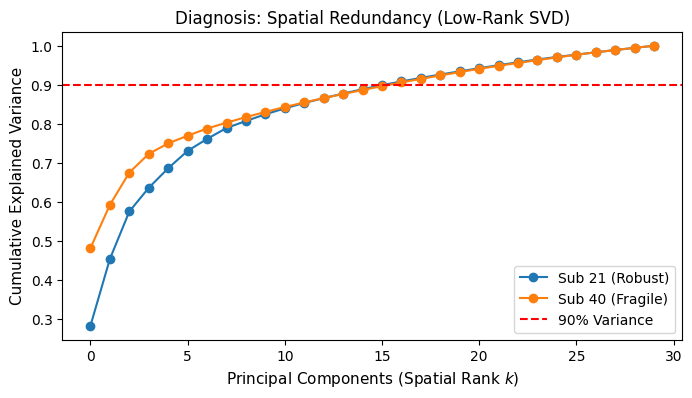

In [10]:
import matplotlib.pyplot as plt

def plot_svd_diagnosis(data, label):
    #  Low-rank approximations via SVD
    U, S, Vh = np.linalg.svd(data, full_matrices=False)
    explained_variance = (S**2) / np.sum(S**2)
    plt.plot(np.cumsum(explained_variance), label=label, marker='o')

plt.figure(figsize=(8, 4))
plot_svd_diagnosis(sub21_data, "Sub 21 (Robust)")
plot_svd_diagnosis(sub40_data, "Sub 40 (Fragile)")
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title("Diagnosis: Spatial Redundancy (Low-Rank SVD)")
plt.xlabel("Principal Components (Spatial Rank $k$)", fontsize=11)
plt.ylabel("Cumulative Explained Variance", fontsize=11)
plt.legend()
plt.show()

### Denoising/Detrending Check (Least Squares)
checks if the "Research Grade" data still has hidden trends that confuse the "Black Box" model.

In [9]:
from sklearn.linear_model import LinearRegression

def check_drift(data, sub_id):
    y = data[0, :].reshape(-1, 1)
    x = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(x, y)  Least Squares
    drift = model.coef_[0][0]
    print(f"Subject {sub_id} Baseline Drift: {drift:.8f}")

check_drift(sub21_data, 21)
check_drift(sub40_data, 40)

Subject 21 Baseline Drift: 0.00000531
Subject 40 Baseline Drift: -0.00000188


AR Diagnosis - Sub 21 (Robust): 0.91% dynamic outliers
AR Diagnosis - Sub 40 (Fragile): 0.30% dynamic outliers


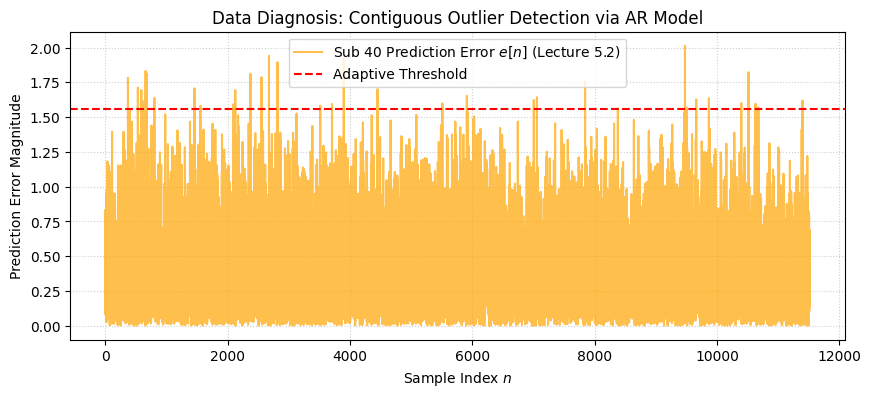

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

def diagnose_ar_outliers(data, p=4, threshold_factor=5):
    """
    Model-based outlier detection (Lecture 5.2) using AR prediction error.
    e[n] = x[n] + sum(a_i * x[n-i])
    """

    x = data[0, :].flatten()

    # Fit AR(p) model
    model = AutoReg(x, lags=p).fit()

    # Calculate prediction error e[n] based on the difference
    # between actual values and model-predicted values
    preds = model.predict(start=p, end=len(x)-1)
    error = np.abs(x[p:] - preds)

    threshold = threshold_factor * np.std(error)
    outlier_indices = np.where(error > threshold)[0]

    contamination_pct = (len(outlier_indices) / len(x)) * 100
    return contamination_pct, error, threshold, outlier_indices

sub21_contam, e21, t21, idx21 = diagnose_ar_outliers(sub21_data)
sub40_contam, e40, t40, idx40 = diagnose_ar_outliers(sub40_data)

print(f"AR Diagnosis - Sub 21 (Robust): {sub21_contam:.2f}% dynamic outliers")
print(f"AR Diagnosis - Sub 40 (Fragile): {sub40_contam:.2f}% dynamic outliers")

plt.figure(figsize=(10, 4))
plt.plot(e40, label="Sub 40 Prediction Error $e[n]$ (Lecture 5.2)", color='orange', alpha=0.7)
plt.axhline(y=t40, color='red', linestyle='--', label="Adaptive Threshold")
plt.title("Data Diagnosis: Contiguous Outlier Detection via AR Model")
plt.xlabel("Sample Index $n$")
plt.ylabel("Prediction Error Magnitude")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Baseline Model

In [ ]:
!find /content -name "Task.py"

/content/EEG-Deformer/EEG-Deformer/Task.py


In [ ]:
%%writefile /content/EEG-Deformer/EEG-Deformer/Task.py
from models.model_handler import DLModel
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from utils import *
import torch

def LOSO(test_idx: list, subjects: list, experiment_ID, logs_name, args):
    pl.seed_everything(seed=args.random_seed)
    torch.manual_seed(args.random_seed)
    torch.backends.cudnn.deterministic = True
    # load test data
    load_path = osp.join(args.load_path, 'data_{}_{}_{}'.format(args.data_format, args.dataset, args.label_type))
    data_test, label_test = load_data(load_path=load_path, load_idx=test_idx, concat=True)
    # load training data
    train_idx = [item for item in subjects if item not in test_idx]
    data_train, label_train = load_data(load_path=load_path, load_idx=train_idx, concat=True)
    train_idx, val_idx = get_validation_set(train_idx=np.arange(data_train.shape[0]), val_rate=args.val_rate, shuffle=True)
    data_val, label_val = data_train[val_idx], label_train[val_idx]
    data_train, label_train = data_train[train_idx], label_train[train_idx]
    # normalize the data
    data_train, data_val, data_test = normalize(train=data_train, val=data_val, test=data_test)

    print('Train:{} Val:{} Test:{}'.format(data_train.shape, data_val.shape, data_test.shape))
    idx, _ = get_channel_info(load_path=load_path, graph_type=args.graph_type)
    # prepare dataloaders
    train_loader = prepare_data_for_training(data=data_train, label=label_train, idx=idx, batch_size=args.batch_size, shuffle=True)
    val_loader = prepare_data_for_training(data=data_val, label=label_val, idx=idx, batch_size=args.batch_size, shuffle=False)
    test_loader = prepare_data_for_training(data=data_test, label=label_test, idx=idx, batch_size=1000, shuffle=False)

    # train and test the model
    model = DLModel(config=args)
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode='max')
    ensure_path(args.save_path)
    logger = TensorBoardLogger(save_dir=args.save_path, version=experiment_ID, name=logs_name)

    if args.mixed_precision:
        trainer = pl.Trainer(accelerator="gpu", devices=[args.gpu], max_epochs=args.max_epoch, logger=logger, callbacks=[checkpoint_callback], precision='16-mixed')
    else:
        trainer = pl.Trainer(accelerator="gpu", devices=[args.gpu], max_epochs=args.max_epoch, logger=logger, callbacks=[checkpoint_callback])

    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_val_metrics = trainer.checkpoint_callback.best_model_score.item()
    print(f"Loading best model weights from: {best_model_path}")

    # Force weights_only=False
    checkpoint = torch.load(best_model_path, map_location=lambda storage, loc: storage, weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

    results = trainer.test(model=model, dataloaders=test_loader)
    results[0]['best_val'] = best_val_metrics
    return results

Overwriting /content/EEG-Deformer/EEG-Deformer/Task.py


In [ ]:
%cd /content/EEG-Deformer/EEG-Deformer/
!python main_FATIG.py --model Deformer --full-run 1

Streaming output truncated to the last 5000 lines.
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 50.16it/s]
Epoch 29: 100% 35/35 [00:03<00:00, 10.13it/s, v_num=ub41, val_loss=0.448, val_acc=0.861, val_f1=0.848, train_loss=0.164, train_acc=0.930, train_f1=0.927]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 49.37it/s]
Epoch 30: 100% 35/35 [00:03<00:00, 10.14it/s, v_num=ub41, val_loss=0.669, val_acc=0.816, val_f1=0.782, train_loss=0.149, train_acc=0.939, train_f1=0.936]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 49.80it/s]
Epoch 31: 100% 35/35 [00:03<00:00, 10.15it/s, v_num=ub41, val_loss=0.500, val_acc=0.848, val_f1=0.829, train_loss=0.165, train_acc=0.935, train_f1=0.931]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
V

In [ ]:
# !mkdir -p /content/drive/MyDrive/MVA/time-series-project/final_results/baseline

!cp -r /content/EEG-Deformer/EEG-Deformer/save/logs_FATIG_Deformer/ /content/drive/MyDrive/MVA/time-series-project/final_results/baseline/

# DREAMER Experiment

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, Dataloader
import numpy as np
from tqdm import tqdm
import os
import json
from datetime import datetime
import sys
import scipy.io as sio
from sklearn.preprocessing import StandardScaler

from EEGDeformer import Deformer

### Application of EEG-Deformer on DREAMER database

In [ ]:
class DREAMERDataset(Dataset):

    def __init__(self, data_path, task='valence', segment_length=384, overlap=0.5,
                 split='train', test_size=0.2, random_state=42, normalize=True,
                 binary_classification=True, threshold=3):

        self.data_path = data_path
        self.task = task
        self.segment_length = segment_length
        self.overlap = overlap
        self.normalize = normalize
        self.binary_classification = binary_classification
        self.threshold = threshold

        self.data, self.labels = self._load_and_process_data()

        X_train, X_test, y_train, y_test = train_test_split(
            self.data, self.labels, test_size=test_size,
            random_state=random_state, stratify=self.labels
        )

        if split == 'train':
            self.data = X_train
            self.labels = y_train
        else:
            self.data = X_test
            self.labels = y_test

        if self.normalize:
            self._normalize_data()

    def _load_and_process_data(self):
        print(f"Loading DREAMER dataset from {self.data_path}...")

        mat_data = sio.loadmat(self.data_path)
        dreamer = mat_data['DREAMER']

        all_segments = []
        all_labels = []

        data_field = dreamer['Data'][0, 0]
        num_subjects = data_field.shape[1]

        print(f"Processing {num_subjects} subjects...")

        for subject_idx in range(num_subjects):
            subject_data = data_field[0, subject_idx]

            eeg_struct = subject_data['EEG'][0, 0]

            if self.task == 'valence':
                scores = subject_data['ScoreValence'][0, 0].flatten()
            elif self.task == 'arousal':
                scores = subject_data['ScoreArousal'][0, 0].flatten()
            elif self.task == 'dominance':
                scores = subject_data['ScoreDominance'][0, 0].flatten()
            else:
                raise ValueError(f"Unknown task: {self.task}")

            stimuli_data = eeg_struct['stimuli'][0, 0]
            num_videos = stimuli_data.shape[0]

            for video_idx in range(num_videos):
                eeg_recording = stimuli_data[video_idx, 0]

                if eeg_recording.size == 0:
                    continue

                label = scores[video_idx]

                if self.binary_classification:
                    label = 1 if label > self.threshold else 0
                else:
                    label = int(label) - 1

                segments = self._segment_signal(eeg_recording)

                for segment in segments:
                    all_segments.append(segment)
                    all_labels.append(label)

        print(f"Generated {len(all_segments)} segments")
        print(f"Label distribution: {np.bincount(all_labels)}")

        return np.array(all_segments), np.array(all_labels)

    def _segment_signal(self, signal):
        num_samples = signal.shape[0]
        step_size = int(self.segment_length * (1 - self.overlap))

        segments = []
        start = 0

        while start + self.segment_length <= num_samples:
            segment = signal[start:start + self.segment_length, :]
            segment = segment.T
            segments.append(segment)
            start += step_size

        return segments

    def _normalize_data(self):
        original_shape = self.data.shape
        reshaped = self.data.reshape(-1, self.data.shape[-1])

        scaler = StandardScaler()
        normalized = scaler.fit_transform(reshaped.T).T

        self.data = normalized.reshape(original_shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.FloatTensor(self.data[idx])
        label = torch.LongTensor([self.labels[idx]])[0]

        return data, label

In [ ]:
def get_dreamer_dataloaders(data_path, task='valence', segment_length=384,
                            batch_size=32, num_workers=4, **kwargs):
    """
    Create train and test dataloaders for DREAMER dataset
    """

    train_dataset = DREAMERDataset(
        data_path=data_path,
        task=task,
        segment_length=segment_length,
        split='train',
        **kwargs
    )

    test_dataset = DREAMERDataset(
        data_path=data_path,
        task=task,
        segment_length=segment_length,
        split='test',
        **kwargs
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, test_loader

In [ ]:
class EEGDeformerTrainer:
    """Trainer class for EEGDeformer on DREAMER dataset"""

    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"Using device: {self.device}")

        self.train_loader, self.test_loader = get_dreamer_dataloaders(
            data_path=config['data_path'],
            task=config['task'],
            segment_length=config['segment_length'],
            batch_size=config['batch_size'],
            overlap=config.get('overlap', 0.5),
            test_size=config.get('test_size', 0.2),
            random_state=config.get('random_state', 42),
            normalize=config.get('normalize', True),
            binary_classification=config.get('binary_classification', True),
            threshold=config.get('threshold', 3)
        )

        self.model = Deformer(
            num_chan=14,
            num_time=config['segment_length'],
            temporal_kernel=config.get('temporal_kernel', 13),
            num_kernel=config.get('num_kernel', 64),
            num_classes=config['num_classes'],
            depth=config.get('depth', 4),
            heads=config.get('heads', 16),
            mlp_dim=config.get('mlp_dim', 16),
            dim_head=config.get('dim_head', 16),
            dropout=config.get('dropout', 0.5)
        ).to(self.device)

        print(f"\nModel parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config.get('weight_decay', 0.01)
        )

        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=config['num_epochs'],
            eta_min=config.get('min_lr', 1e-6)
        )
        self.best_acc = 0.0
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }

        self.save_dir = config.get('save_dir', 'checkpoints')
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()

        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for data, labels in pbar:
            data, labels = data.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        avg_loss = train_loss / len(self.train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def validate(self):
        """Validate the model"""
        self.model.eval()

        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            pbar = tqdm(self.test_loader, desc='Validation')
            for data, labels in pbar:
                data, labels = data.to(self.device), labels.to(self.device)

                outputs = self.model(data)
                loss = self.criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*correct/total:.2f}%'
                })

        avg_loss = test_loss / len(self.test_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self):
        """Full training loop"""
        print(f"\n{'='*60}")
        print(f"Starting training for task: {self.config['task'].upper()}")
        print(f"{'='*60}\n")

        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")
            print('-' * 60)

            train_loss, train_acc = self.train_epoch()

            test_loss, test_acc = self.validate()

            self.scheduler.step()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)

            print(f"\nEpoch {epoch+1} Results:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
            print(f"  Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")

            if test_acc > self.best_acc:
                self.best_acc = test_acc
                self.save_checkpoint(epoch, is_best=True)
                print(f"  ✓ New best accuracy: {test_acc:.2f}%")

            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(epoch, is_best=False)

        print(f"\n{'='*60}")
        print(f"Training completed!")
        print(f"Best test accuracy: {self.best_acc:.2f}%")
        print(f"{'='*60}\n")

        self.save_results()

    def save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_acc': self.best_acc,
            'config': self.config,
            'history': self.history
        }

        if is_best:
            path = os.path.join(self.save_dir, f'best_model_{self.config["task"]}.pth')
            torch.save(checkpoint, path)
        else:
            path = os.path.join(self.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, path)

    def save_results(self):
        """Save training results and config"""
        results = {
            'config': self.config,
            'best_accuracy': self.best_acc,
            'history': self.history,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        path = os.path.join(self.save_dir, f'results_{self.config["task"]}.json')
        with open(path, 'w') as f:
            json.dump(results, f, indent=4)

        print(f"Results saved to {path}")

In [ ]:
config = {
    # Data parameters
    'data_path': 'DREAMER.mat',
    'task': 'dominance',  # Alternate between 'valence', 'arousal', 'dominance'
    'segment_length': 384,  # 3 seconds at 128 Hz (DREAMER sampling rate)
    'overlap': 0.5,
    'test_size': 0.2,
    'random_state': 42,
    'normalize': True,
    'binary_classification': True,  # High/Low
    'threshold': 3,  # For binary classification

    # Model parameters
    'num_classes': 2,  # Binary classification
    'temporal_kernel': 13,
    'num_kernel': 64,
    'depth': 4,
    'heads': 16,
    'mlp_dim': 16,
    'dim_head': 16,
    'dropout': 0.5,

    # Training parameters
    'batch_size': 32,
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'weight_decay': 0.01,
    'min_lr': 1e-6,

    'save_dir': 'checkpoints/dreamer',
    }

trainer = EEGDeformerTrainer(config)
trainer.train()

Using device: cuda
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [26166 30414]
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [26166 30414]

Model parameters: 477,394

Starting training for task: DOMINANCE


Epoch 1/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.09it/s, loss=0.5029, acc=64.39%]



Epoch 1 Results:
  Train Loss: 0.6912 | Train Acc: 56.39%
  Test Loss:  0.6208 | Test Acc:  64.39%
  Learning Rate: 0.001000
  ✓ New best accuracy: 64.39%

Epoch 2/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 130.67it/s, loss=0.4683, acc=64.28%]



Epoch 2 Results:
  Train Loss: 0.6456 | Train Acc: 62.22%
  Test Loss:  0.6158 | Test Acc:  64.28%
  Learning Rate: 0.000999

Epoch 3/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.69it/s, loss=0.4085, acc=66.99%]



Epoch 3 Results:
  Train Loss: 0.6209 | Train Acc: 64.38%
  Test Loss:  0.6027 | Test Acc:  66.99%
  Learning Rate: 0.000998
  ✓ New best accuracy: 66.99%

Epoch 4/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 141.18it/s, loss=0.3835, acc=67.99%]



Epoch 4 Results:
  Train Loss: 0.6068 | Train Acc: 65.83%
  Test Loss:  0.5794 | Test Acc:  67.99%
  Learning Rate: 0.000996
  ✓ New best accuracy: 67.99%

Epoch 5/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.35it/s, loss=0.3908, acc=67.44%]



Epoch 5 Results:
  Train Loss: 0.5962 | Train Acc: 66.70%
  Test Loss:  0.5897 | Test Acc:  67.44%
  Learning Rate: 0.000994

Epoch 6/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.81it/s, loss=0.3929, acc=69.29%]



Epoch 6 Results:
  Train Loss: 0.5913 | Train Acc: 67.13%
  Test Loss:  0.5613 | Test Acc:  69.29%
  Learning Rate: 0.000991
  ✓ New best accuracy: 69.29%

Epoch 7/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.52it/s, loss=0.3944, acc=68.89%]



Epoch 7 Results:
  Train Loss: 0.5830 | Train Acc: 68.09%
  Test Loss:  0.5706 | Test Acc:  68.89%
  Learning Rate: 0.000988

Epoch 8/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.37it/s, loss=0.3275, acc=69.41%]



Epoch 8 Results:
  Train Loss: 0.5755 | Train Acc: 68.47%
  Test Loss:  0.5688 | Test Acc:  69.41%
  Learning Rate: 0.000984
  ✓ New best accuracy: 69.41%

Epoch 9/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.97it/s, loss=0.4375, acc=68.15%]



Epoch 9 Results:
  Train Loss: 0.5741 | Train Acc: 68.84%
  Test Loss:  0.5797 | Test Acc:  68.15%
  Learning Rate: 0.000980

Epoch 10/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.89it/s, loss=0.4621, acc=68.17%]



Epoch 10 Results:
  Train Loss: 0.5633 | Train Acc: 69.66%
  Test Loss:  0.5803 | Test Acc:  68.17%
  Learning Rate: 0.000976

Epoch 11/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.59it/s, loss=0.3208, acc=70.55%]



Epoch 11 Results:
  Train Loss: 0.5601 | Train Acc: 69.89%
  Test Loss:  0.5497 | Test Acc:  70.55%
  Learning Rate: 0.000970
  ✓ New best accuracy: 70.55%

Epoch 12/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.04it/s, loss=0.3712, acc=69.95%]



Epoch 12 Results:
  Train Loss: 0.5567 | Train Acc: 70.31%
  Test Loss:  0.5692 | Test Acc:  69.95%
  Learning Rate: 0.000965

Epoch 13/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 133.09it/s, loss=0.3990, acc=68.64%]



Epoch 13 Results:
  Train Loss: 0.5495 | Train Acc: 70.63%
  Test Loss:  0.5939 | Test Acc:  68.64%
  Learning Rate: 0.000959

Epoch 14/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.29it/s, loss=0.2663, acc=71.36%]



Epoch 14 Results:
  Train Loss: 0.5470 | Train Acc: 70.87%
  Test Loss:  0.5434 | Test Acc:  71.36%
  Learning Rate: 0.000952
  ✓ New best accuracy: 71.36%

Epoch 15/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.96it/s, loss=0.3725, acc=70.52%]



Epoch 15 Results:
  Train Loss: 0.5447 | Train Acc: 70.95%
  Test Loss:  0.5727 | Test Acc:  70.52%
  Learning Rate: 0.000946

Epoch 16/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.42it/s, loss=0.3602, acc=71.26%]



Epoch 16 Results:
  Train Loss: 0.5430 | Train Acc: 71.38%
  Test Loss:  0.5424 | Test Acc:  71.26%
  Learning Rate: 0.000938

Epoch 17/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.77it/s, loss=0.2785, acc=68.90%]



Epoch 17 Results:
  Train Loss: 0.5357 | Train Acc: 72.01%
  Test Loss:  0.5940 | Test Acc:  68.90%
  Learning Rate: 0.000930

Epoch 18/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 132.26it/s, loss=0.4618, acc=71.86%]



Epoch 18 Results:
  Train Loss: 0.5329 | Train Acc: 71.97%
  Test Loss:  0.5358 | Test Acc:  71.86%
  Learning Rate: 0.000922
  ✓ New best accuracy: 71.86%

Epoch 19/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.10it/s, loss=0.3543, acc=71.32%]



Epoch 19 Results:
  Train Loss: 0.5304 | Train Acc: 72.43%
  Test Loss:  0.5441 | Test Acc:  71.32%
  Learning Rate: 0.000914

Epoch 20/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 133.60it/s, loss=0.3122, acc=72.16%]



Epoch 20 Results:
  Train Loss: 0.5241 | Train Acc: 72.66%
  Test Loss:  0.5295 | Test Acc:  72.16%
  Learning Rate: 0.000905
  ✓ New best accuracy: 72.16%

Epoch 21/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 131.17it/s, loss=0.4611, acc=70.93%]



Epoch 21 Results:
  Train Loss: 0.5208 | Train Acc: 73.10%
  Test Loss:  0.5550 | Test Acc:  70.93%
  Learning Rate: 0.000895

Epoch 22/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 124.53it/s, loss=0.3289, acc=71.77%]



Epoch 22 Results:
  Train Loss: 0.5163 | Train Acc: 73.32%
  Test Loss:  0.5382 | Test Acc:  71.77%
  Learning Rate: 0.000885

Epoch 23/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.37it/s, loss=0.2899, acc=72.43%]



Epoch 23 Results:
  Train Loss: 0.5124 | Train Acc: 73.74%
  Test Loss:  0.5272 | Test Acc:  72.43%
  Learning Rate: 0.000875
  ✓ New best accuracy: 72.43%

Epoch 24/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 126.76it/s, loss=0.3290, acc=73.00%]



Epoch 24 Results:
  Train Loss: 0.5110 | Train Acc: 73.91%
  Test Loss:  0.5198 | Test Acc:  73.00%
  Learning Rate: 0.000865
  ✓ New best accuracy: 73.00%

Epoch 25/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 128.05it/s, loss=0.3614, acc=73.13%]



Epoch 25 Results:
  Train Loss: 0.5088 | Train Acc: 73.79%
  Test Loss:  0.5138 | Test Acc:  73.13%
  Learning Rate: 0.000854
  ✓ New best accuracy: 73.13%

Epoch 26/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 121.85it/s, loss=0.2930, acc=72.93%]



Epoch 26 Results:
  Train Loss: 0.5008 | Train Acc: 74.53%
  Test Loss:  0.5233 | Test Acc:  72.93%
  Learning Rate: 0.000842

Epoch 27/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 129.07it/s, loss=0.3810, acc=71.31%]



Epoch 27 Results:
  Train Loss: 0.4997 | Train Acc: 74.41%
  Test Loss:  0.5647 | Test Acc:  71.31%
  Learning Rate: 0.000831

Epoch 28/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 126.75it/s, loss=0.3139, acc=73.59%]



Epoch 28 Results:
  Train Loss: 0.4959 | Train Acc: 74.72%
  Test Loss:  0.5192 | Test Acc:  73.59%
  Learning Rate: 0.000819
  ✓ New best accuracy: 73.59%

Epoch 29/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 127.56it/s, loss=0.2746, acc=73.14%]



Epoch 29 Results:
  Train Loss: 0.4919 | Train Acc: 75.08%
  Test Loss:  0.5136 | Test Acc:  73.14%
  Learning Rate: 0.000807

Epoch 30/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 126.35it/s, loss=0.2820, acc=71.95%]



Epoch 30 Results:
  Train Loss: 0.4891 | Train Acc: 75.41%
  Test Loss:  0.5425 | Test Acc:  71.95%
  Learning Rate: 0.000794

Epoch 31/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 121.76it/s, loss=0.1965, acc=72.02%]



Epoch 31 Results:
  Train Loss: 0.4801 | Train Acc: 76.28%
  Test Loss:  0.5510 | Test Acc:  72.02%
  Learning Rate: 0.000781

Epoch 32/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 130.10it/s, loss=0.3429, acc=72.70%]



Epoch 32 Results:
  Train Loss: 0.4764 | Train Acc: 76.39%
  Test Loss:  0.5349 | Test Acc:  72.70%
  Learning Rate: 0.000768

Epoch 33/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 121.57it/s, loss=0.3055, acc=71.77%]



Epoch 33 Results:
  Train Loss: 0.4680 | Train Acc: 77.12%
  Test Loss:  0.5510 | Test Acc:  71.77%
  Learning Rate: 0.000755

Epoch 34/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 120.94it/s, loss=0.2556, acc=73.01%]



Epoch 34 Results:
  Train Loss: 0.4616 | Train Acc: 77.45%
  Test Loss:  0.5225 | Test Acc:  73.01%
  Learning Rate: 0.000741

Epoch 35/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 128.63it/s, loss=0.2537, acc=72.22%]



Epoch 35 Results:
  Train Loss: 0.4557 | Train Acc: 78.09%
  Test Loss:  0.5577 | Test Acc:  72.22%
  Learning Rate: 0.000727

Epoch 36/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 123.67it/s, loss=0.3442, acc=70.71%]



Epoch 36 Results:
  Train Loss: 0.4484 | Train Acc: 78.54%
  Test Loss:  0.6044 | Test Acc:  70.71%
  Learning Rate: 0.000713

Epoch 37/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 128.16it/s, loss=0.2342, acc=71.91%]



Epoch 37 Results:
  Train Loss: 0.4381 | Train Acc: 79.01%
  Test Loss:  0.5852 | Test Acc:  71.91%
  Learning Rate: 0.000699

Epoch 38/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 124.47it/s, loss=0.3110, acc=71.57%]



Epoch 38 Results:
  Train Loss: 0.4277 | Train Acc: 79.85%
  Test Loss:  0.5844 | Test Acc:  71.57%
  Learning Rate: 0.000684

Epoch 39/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 127.05it/s, loss=0.3624, acc=72.18%]



Epoch 39 Results:
  Train Loss: 0.4165 | Train Acc: 80.44%
  Test Loss:  0.6099 | Test Acc:  72.18%
  Learning Rate: 0.000670

Epoch 40/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 131.11it/s, loss=0.3734, acc=71.36%]



Epoch 40 Results:
  Train Loss: 0.4078 | Train Acc: 81.13%
  Test Loss:  0.6267 | Test Acc:  71.36%
  Learning Rate: 0.000655

Epoch 41/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 127.54it/s, loss=0.3021, acc=71.56%]



Epoch 41 Results:
  Train Loss: 0.3941 | Train Acc: 81.83%
  Test Loss:  0.6181 | Test Acc:  71.56%
  Learning Rate: 0.000640

Epoch 42/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.73it/s, loss=0.2915, acc=71.38%]



Epoch 42 Results:
  Train Loss: 0.3831 | Train Acc: 82.51%
  Test Loss:  0.6323 | Test Acc:  71.38%
  Learning Rate: 0.000625

Epoch 43/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.05it/s, loss=0.4363, acc=70.08%]



Epoch 43 Results:
  Train Loss: 0.3717 | Train Acc: 83.14%
  Test Loss:  0.7330 | Test Acc:  70.08%
  Learning Rate: 0.000609

Epoch 44/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.65it/s, loss=0.2568, acc=70.63%]



Epoch 44 Results:
  Train Loss: 0.3647 | Train Acc: 83.44%
  Test Loss:  0.6766 | Test Acc:  70.63%
  Learning Rate: 0.000594

Epoch 45/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.89it/s, loss=0.3945, acc=69.56%]



Epoch 45 Results:
  Train Loss: 0.3469 | Train Acc: 84.59%
  Test Loss:  0.7850 | Test Acc:  69.56%
  Learning Rate: 0.000579

Epoch 46/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.72it/s, loss=0.4378, acc=69.39%]



Epoch 46 Results:
  Train Loss: 0.3335 | Train Acc: 85.13%
  Test Loss:  0.8307 | Test Acc:  69.39%
  Learning Rate: 0.000563

Epoch 47/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.73it/s, loss=0.4293, acc=69.21%]



Epoch 47 Results:
  Train Loss: 0.3229 | Train Acc: 85.69%
  Test Loss:  0.8910 | Test Acc:  69.21%
  Learning Rate: 0.000548

Epoch 48/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.39it/s, loss=0.5237, acc=68.98%]



Epoch 48 Results:
  Train Loss: 0.3149 | Train Acc: 86.07%
  Test Loss:  0.9537 | Test Acc:  68.98%
  Learning Rate: 0.000532

Epoch 49/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.19it/s, loss=0.6406, acc=68.65%]



Epoch 49 Results:
  Train Loss: 0.3039 | Train Acc: 86.71%
  Test Loss:  0.9547 | Test Acc:  68.65%
  Learning Rate: 0.000516

Epoch 50/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.03it/s, loss=0.6946, acc=69.61%]



Epoch 50 Results:
  Train Loss: 0.2913 | Train Acc: 87.27%
  Test Loss:  0.8822 | Test Acc:  69.61%
  Learning Rate: 0.000501

Epoch 51/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 132.97it/s, loss=0.9350, acc=68.66%]



Epoch 51 Results:
  Train Loss: 0.2765 | Train Acc: 87.99%
  Test Loss:  1.1055 | Test Acc:  68.66%
  Learning Rate: 0.000485

Epoch 52/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.58it/s, loss=0.7410, acc=69.07%]



Epoch 52 Results:
  Train Loss: 0.2701 | Train Acc: 88.18%
  Test Loss:  1.0145 | Test Acc:  69.07%
  Learning Rate: 0.000469

Epoch 53/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.87it/s, loss=0.8339, acc=69.14%]



Epoch 53 Results:
  Train Loss: 0.2585 | Train Acc: 88.93%
  Test Loss:  0.9657 | Test Acc:  69.14%
  Learning Rate: 0.000453

Epoch 54/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.96it/s, loss=0.7243, acc=68.99%]



Epoch 54 Results:
  Train Loss: 0.2465 | Train Acc: 89.45%
  Test Loss:  1.0098 | Test Acc:  68.99%
  Learning Rate: 0.000438

Epoch 55/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.38it/s, loss=0.6554, acc=67.61%]



Epoch 55 Results:
  Train Loss: 0.2404 | Train Acc: 89.73%
  Test Loss:  1.1967 | Test Acc:  67.61%
  Learning Rate: 0.000422

Epoch 56/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.23it/s, loss=0.8396, acc=68.18%]



Epoch 56 Results:
  Train Loss: 0.2293 | Train Acc: 90.19%
  Test Loss:  1.2269 | Test Acc:  68.18%
  Learning Rate: 0.000407

Epoch 57/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.53it/s, loss=0.8654, acc=68.12%]



Epoch 57 Results:
  Train Loss: 0.2181 | Train Acc: 90.82%
  Test Loss:  1.1975 | Test Acc:  68.12%
  Learning Rate: 0.000392

Epoch 58/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.44it/s, loss=0.9413, acc=67.66%]



Epoch 58 Results:
  Train Loss: 0.2064 | Train Acc: 91.36%
  Test Loss:  1.3229 | Test Acc:  67.66%
  Learning Rate: 0.000376

Epoch 59/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.57it/s, loss=0.9011, acc=68.09%]



Epoch 59 Results:
  Train Loss: 0.2046 | Train Acc: 91.33%
  Test Loss:  1.3022 | Test Acc:  68.09%
  Learning Rate: 0.000361

Epoch 60/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.06it/s, loss=1.0836, acc=68.34%]



Epoch 60 Results:
  Train Loss: 0.1911 | Train Acc: 92.08%
  Test Loss:  1.2086 | Test Acc:  68.34%
  Learning Rate: 0.000346

Epoch 61/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.06it/s, loss=0.9965, acc=67.92%]



Epoch 61 Results:
  Train Loss: 0.1794 | Train Acc: 92.62%
  Test Loss:  1.4089 | Test Acc:  67.92%
  Learning Rate: 0.000331

Epoch 62/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 131.34it/s, loss=1.2234, acc=67.27%]



Epoch 62 Results:
  Train Loss: 0.1727 | Train Acc: 92.84%
  Test Loss:  1.4454 | Test Acc:  67.27%
  Learning Rate: 0.000317

Epoch 63/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.95it/s, loss=1.0926, acc=67.30%]



Epoch 63 Results:
  Train Loss: 0.1670 | Train Acc: 93.10%
  Test Loss:  1.3541 | Test Acc:  67.30%
  Learning Rate: 0.000302

Epoch 64/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 131.67it/s, loss=1.2799, acc=67.12%]



Epoch 64 Results:
  Train Loss: 0.1557 | Train Acc: 93.62%
  Test Loss:  1.5875 | Test Acc:  67.12%
  Learning Rate: 0.000288

Epoch 65/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 133.28it/s, loss=1.4967, acc=67.21%]



Epoch 65 Results:
  Train Loss: 0.1478 | Train Acc: 94.01%
  Test Loss:  1.6423 | Test Acc:  67.21%
  Learning Rate: 0.000274

Epoch 66/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.86it/s, loss=1.0794, acc=66.76%]



Epoch 66 Results:
  Train Loss: 0.1444 | Train Acc: 94.10%
  Test Loss:  1.6923 | Test Acc:  66.76%
  Learning Rate: 0.000260

Epoch 67/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 131.78it/s, loss=1.3264, acc=66.97%]



Epoch 67 Results:
  Train Loss: 0.1402 | Train Acc: 94.29%
  Test Loss:  1.6328 | Test Acc:  66.97%
  Learning Rate: 0.000246

Epoch 68/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.72it/s, loss=1.3417, acc=67.43%]



Epoch 68 Results:
  Train Loss: 0.1321 | Train Acc: 94.74%
  Test Loss:  1.7444 | Test Acc:  67.43%
  Learning Rate: 0.000233

Epoch 69/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 141.00it/s, loss=1.1178, acc=67.06%]



Epoch 69 Results:
  Train Loss: 0.1229 | Train Acc: 95.18%
  Test Loss:  1.6932 | Test Acc:  67.06%
  Learning Rate: 0.000220

Epoch 70/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.58it/s, loss=1.3297, acc=67.62%]



Epoch 70 Results:
  Train Loss: 0.1217 | Train Acc: 95.01%
  Test Loss:  1.7994 | Test Acc:  67.62%
  Learning Rate: 0.000207

Epoch 71/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.93it/s, loss=1.4018, acc=66.98%]



Epoch 71 Results:
  Train Loss: 0.1137 | Train Acc: 95.48%
  Test Loss:  1.9175 | Test Acc:  66.98%
  Learning Rate: 0.000194

Epoch 72/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.03it/s, loss=1.2502, acc=66.89%]



Epoch 72 Results:
  Train Loss: 0.1066 | Train Acc: 95.84%
  Test Loss:  1.9231 | Test Acc:  66.89%
  Learning Rate: 0.000182

Epoch 73/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.33it/s, loss=1.2842, acc=66.67%]



Epoch 73 Results:
  Train Loss: 0.1017 | Train Acc: 95.98%
  Test Loss:  2.0514 | Test Acc:  66.67%
  Learning Rate: 0.000170

Epoch 74/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.21it/s, loss=1.1199, acc=66.25%]



Epoch 74 Results:
  Train Loss: 0.0958 | Train Acc: 96.30%
  Test Loss:  2.0520 | Test Acc:  66.25%
  Learning Rate: 0.000159

Epoch 75/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.18it/s, loss=1.3113, acc=66.72%]



Epoch 75 Results:
  Train Loss: 0.0925 | Train Acc: 96.47%
  Test Loss:  2.0730 | Test Acc:  66.72%
  Learning Rate: 0.000147

Epoch 76/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.36it/s, loss=1.6346, acc=65.95%]



Epoch 76 Results:
  Train Loss: 0.0872 | Train Acc: 96.71%
  Test Loss:  2.3083 | Test Acc:  65.95%
  Learning Rate: 0.000136

Epoch 77/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.09it/s, loss=1.7963, acc=66.59%]



Epoch 77 Results:
  Train Loss: 0.0804 | Train Acc: 96.86%
  Test Loss:  2.2955 | Test Acc:  66.59%
  Learning Rate: 0.000126

Epoch 78/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.87it/s, loss=2.0847, acc=66.12%]



Epoch 78 Results:
  Train Loss: 0.0797 | Train Acc: 96.87%
  Test Loss:  2.4764 | Test Acc:  66.12%
  Learning Rate: 0.000116

Epoch 79/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.02it/s, loss=2.0094, acc=66.42%]



Epoch 79 Results:
  Train Loss: 0.0765 | Train Acc: 97.07%
  Test Loss:  2.3882 | Test Acc:  66.42%
  Learning Rate: 0.000106

Epoch 80/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.48it/s, loss=1.9645, acc=65.88%]



Epoch 80 Results:
  Train Loss: 0.0744 | Train Acc: 97.17%
  Test Loss:  2.5324 | Test Acc:  65.88%
  Learning Rate: 0.000096

Epoch 81/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 140.13it/s, loss=2.0155, acc=66.49%]



Epoch 81 Results:
  Train Loss: 0.0698 | Train Acc: 97.36%
  Test Loss:  2.5295 | Test Acc:  66.49%
  Learning Rate: 0.000087

Epoch 82/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.37it/s, loss=1.8927, acc=66.62%]



Epoch 82 Results:
  Train Loss: 0.0642 | Train Acc: 97.58%
  Test Loss:  2.6242 | Test Acc:  66.62%
  Learning Rate: 0.000079

Epoch 83/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 134.38it/s, loss=2.1346, acc=66.17%]



Epoch 83 Results:
  Train Loss: 0.0604 | Train Acc: 97.76%
  Test Loss:  2.6711 | Test Acc:  66.17%
  Learning Rate: 0.000071

Epoch 84/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 139.69it/s, loss=2.1650, acc=66.08%]



Epoch 84 Results:
  Train Loss: 0.0601 | Train Acc: 97.74%
  Test Loss:  2.7455 | Test Acc:  66.08%
  Learning Rate: 0.000063

Epoch 85/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.80it/s, loss=2.4550, acc=66.00%]



Epoch 85 Results:
  Train Loss: 0.0566 | Train Acc: 97.90%
  Test Loss:  2.8083 | Test Acc:  66.00%
  Learning Rate: 0.000055

Epoch 86/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.63it/s, loss=2.1166, acc=65.82%]



Epoch 86 Results:
  Train Loss: 0.0532 | Train Acc: 97.95%
  Test Loss:  2.9200 | Test Acc:  65.82%
  Learning Rate: 0.000049

Epoch 87/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.92it/s, loss=2.3300, acc=65.46%]



Epoch 87 Results:
  Train Loss: 0.0516 | Train Acc: 98.15%
  Test Loss:  2.9983 | Test Acc:  65.46%
  Learning Rate: 0.000042

Epoch 88/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.69it/s, loss=2.4275, acc=65.92%]



Epoch 88 Results:
  Train Loss: 0.0509 | Train Acc: 98.11%
  Test Loss:  2.9324 | Test Acc:  65.92%
  Learning Rate: 0.000036

Epoch 89/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.74it/s, loss=2.0907, acc=66.08%]



Epoch 89 Results:
  Train Loss: 0.0481 | Train Acc: 98.25%
  Test Loss:  2.9352 | Test Acc:  66.08%
  Learning Rate: 0.000031

Epoch 90/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.26it/s, loss=2.3133, acc=65.62%]



Epoch 90 Results:
  Train Loss: 0.0477 | Train Acc: 98.21%
  Test Loss:  2.9620 | Test Acc:  65.62%
  Learning Rate: 0.000025

Epoch 91/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.44it/s, loss=2.4960, acc=65.72%]



Epoch 91 Results:
  Train Loss: 0.0456 | Train Acc: 98.40%
  Test Loss:  3.0194 | Test Acc:  65.72%
  Learning Rate: 0.000021

Epoch 92/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.46it/s, loss=2.4097, acc=65.84%]



Epoch 92 Results:
  Train Loss: 0.0437 | Train Acc: 98.51%
  Test Loss:  3.0771 | Test Acc:  65.84%
  Learning Rate: 0.000017

Epoch 93/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 133.75it/s, loss=2.5406, acc=65.69%]



Epoch 93 Results:
  Train Loss: 0.0420 | Train Acc: 98.53%
  Test Loss:  3.1005 | Test Acc:  65.69%
  Learning Rate: 0.000013

Epoch 94/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.19it/s, loss=2.5525, acc=65.62%]



Epoch 94 Results:
  Train Loss: 0.0421 | Train Acc: 98.53%
  Test Loss:  3.0703 | Test Acc:  65.62%
  Learning Rate: 0.000010

Epoch 95/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 139.07it/s, loss=2.5203, acc=65.76%]



Epoch 95 Results:
  Train Loss: 0.0409 | Train Acc: 98.59%
  Test Loss:  3.1321 | Test Acc:  65.76%
  Learning Rate: 0.000007

Epoch 96/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 135.59it/s, loss=2.5453, acc=65.71%]



Epoch 96 Results:
  Train Loss: 0.0407 | Train Acc: 98.57%
  Test Loss:  3.1166 | Test Acc:  65.71%
  Learning Rate: 0.000005

Epoch 97/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 132.29it/s, loss=2.6597, acc=65.69%]



Epoch 97 Results:
  Train Loss: 0.0406 | Train Acc: 98.57%
  Test Loss:  3.1337 | Test Acc:  65.69%
  Learning Rate: 0.000003

Epoch 98/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 137.82it/s, loss=2.5514, acc=65.50%]



Epoch 98 Results:
  Train Loss: 0.0381 | Train Acc: 98.68%
  Test Loss:  3.1574 | Test Acc:  65.50%
  Learning Rate: 0.000002

Epoch 99/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 136.08it/s, loss=2.5696, acc=65.76%]



Epoch 99 Results:
  Train Loss: 0.0384 | Train Acc: 98.65%
  Test Loss:  3.1500 | Test Acc:  65.76%
  Learning Rate: 0.000001

Epoch 100/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:02<00:00, 138.58it/s, loss=2.5309, acc=65.55%]



Epoch 100 Results:
  Train Loss: 0.0390 | Train Acc: 98.61%
  Test Loss:  3.1446 | Test Acc:  65.55%
  Learning Rate: 0.000001

Training completed!
Best test accuracy: 73.59%

Results saved to checkpoints/dreamer/results_dominance.json


### Time-length comparison

In [ ]:
def compare_segment_lengths(data_path, task='valence'):
    """Test different time window lengths"""

    segment_lengths = [256, 384, 512, 640]  # 2, 3, 4, 5 seconds
    results = []

    for seg_len in segment_lengths:
        print(f"\n{'='*60}")
        print(f"Testing segment length: {seg_len} samples ({seg_len/128:.1f}s)")
        print(f"{'='*60}")

        config = {
            'data_path': data_path,
            'task': task,
            'segment_length': seg_len,
            'num_time': seg_len,
            'overlap': 0.5,
            'test_size': 0.2,
            'random_state': 42,
            'normalize': True,
            'binary_classification': True,
            'threshold': 3,
            'num_classes': 2,
            'temporal_kernel': 13,
            'num_kernel': 64,
            'depth': 4,
            'heads': 16,
            'mlp_dim': 16,
            'dim_head': 16,
            'dropout': 0.5,
            'batch_size': 32,
            'num_epochs': 30,  # Reduced for quick comparison
            'learning_rate': 1e-3,
            'weight_decay': 0.01,
            'min_lr': 1e-6,
            'save_dir': f'checkpoints/segment_comparison/{task}',
        }

        trainer = EEGDeformerTrainer(config)
        trainer.train()

        results.append({
            'segment_length': seg_len,
            'seconds': seg_len / 128,
            'best_acc': trainer.best_acc
        })

    print(f"\n{'='*60}")
    print("SEGMENT LENGTH COMPARISON")
    print(f"{'='*60}")
    for r in results:
        print(f"{r['segment_length']:4d} samples ({r['seconds']:.1f}s): {r['best_acc']:.2f}%")

    with open(f'segment_length_comparison_{task}.json', 'w') as f:
        json.dump({
            'task': task,
            'results': results,
            'best': max(results, key=lambda x: x['best_acc'])
        }, f, indent=4)

    return results

In [ ]:
for task in ['valence', 'arousal', 'dominance']:
    print(f"\n{'='*60}")
    print(f"TESTING SEGMENT LENGTHS FOR {task.upper()}")
    print(f"{'='*60}")
    results = compare_segment_lengths('DREAMER.mat', task)


TESTING SEGMENT LENGTHS FOR VALENCE

Testing segment length: 256 samples (2.0s)
Using device: cuda
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 85330 segments
Label distribution: [50259 35071]
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 85330 segments
Label distribution: [50259 35071]


KeyError: 'num_classes'

### Comparison between different architectures

CNN model

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, num_channels=14, segment_length=384, num_classes=2):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

LSTM model

In [ ]:
class SimpleLSTM(nn.Module):

    def __init__(self, num_channels=14, segment_length=384, num_classes=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=num_channels,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, time, channels)

        _, (h_n, _) = self.lstm(x)

        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h = torch.cat([h_forward, h_backward], dim=1)

        return self.classifier(h)

Train and compare architectures

In [ ]:
def train_model(model, train_loader, test_loader, device, num_epochs=30, model_name="Model"):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

    best_acc = 0.0
    history = {'train_acc': [], 'test_acc': []}

    print(f"\nTraining {model_name}...")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_correct = 0
        train_total = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_acc = 100. * train_correct / train_total

        # Test
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_acc = 100. * test_correct / test_total

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train={train_acc:.2f}%, Test={test_acc:.2f}%, Best={best_acc:.2f}%")

    print(f"{model_name} - Best Accuracy: {best_acc:.2f}%\n")

    return {
        'best_acc': best_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_test_acc': history['test_acc'][-1],
        'history': history,
        'num_params': sum(p.numel() for p in model.parameters())
    }


def compare_architectures(data_path='DREAMER.mat', task='valence', num_epochs=30):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    train_loader, test_loader = get_dreamer_dataloaders(
        data_path=data_path,
        task=task,
        segment_length=384,
        batch_size=32
    )

    results = {}

    print(f"\n{'='*80}")
    print(f"ARCHITECTURE COMPARISON - {task.upper()}")
    print(f"{'='*80}\n")

    #  Simple CNN
    print(f"\n{'='*60}")
    print("1. SIMPLE CNN BASELINE")
    print(f"{'='*60}")

    cnn_model = SimpleCNN(num_channels=14, segment_length=384, num_classes=2).to(device)
    results['CNN'] = train_model(cnn_model, train_loader, test_loader, device, num_epochs, "CNN")

    #  LSTM
    print(f"\n{'='*60}")
    print("2. LSTM BASELINE")
    print(f"{'='*60}")

    lstm_model = SimpleLSTM(num_channels=14, segment_length=384, num_classes=2).to(device)
    results['LSTM'] = train_model(lstm_model, train_loader, test_loader, device, num_epochs, "LSTM")

    # EEGDeformer
    print(f"\n{'='*60}")
    print("3. EEGDEFORMER (TRANSFORMER)")
    print(f"{'='*60}")

    deformer_model = Deformer(
        num_chan=14,
        num_time=384,
        temporal_kernel=13,
        num_kernel=64,
        num_classes=2,
        depth=4,
        heads=16,
        mlp_dim=16,
        dim_head=16,
        dropout=0.5
    ).to(device)

    results['EEGDeformer'] = train_model(deformer_model, train_loader, test_loader,
                                         device, num_epochs, "EEGDeformer")

    print(f"\n{'='*80}")
    print(f"RESULTS SUMMARY - {task.upper()}")
    print(f"{'='*80}")
    print(f"{'Architecture':<20} {'Parameters':<15} {'Best Acc':<12} {'Final Test':<12}")
    print(f"{'-'*80}")

    for name, result in results.items():
        print(f"{name:<20} {result['num_params']:>14,} "
              f"{result['best_acc']:>11.2f}% {result['final_test_acc']:>11.2f}%")

    cnn_acc = results['CNN']['best_acc']
    lstm_acc = results['LSTM']['best_acc']
    deformer_acc = results['EEGDeformer']['best_acc']

    print(f"{'-'*80}")
    print(f"EEGDeformer vs CNN:  +{deformer_acc - cnn_acc:.2f}%")
    print(f"EEGDeformer vs LSTM: +{deformer_acc - lstm_acc:.2f}%")
    print(f"{'='*80}\n")

    output = {
        'task': task,
        'num_epochs': num_epochs,
        'results': {name: {k: v for k, v in r.items() if k != 'history'}
                   for name, r in results.items()},
        'full_results': results
    }

    output_file = f'architecture_comparison_{task}.json'
    with open(output_file, 'w') as f:
        json.dump(output, f, indent=4)

    print(f"Results saved to {output_file}\n")

    return results

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, default='DREAMER.mat')
parser.add_argument('--task', type=str, default='valence',
                   choices=['valence', 'arousal', 'dominance', 'all'])
parser.add_argument('--epochs', type=int, default=30)

args, unknown = parser.parse_known_args()

compare_architectures(args.data_path, args.task, args.epochs)

Using device: cuda

Loading DREAMER dataset...
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]

ARCHITECTURE COMPARISON - VALENCE


1. SIMPLE CNN BASELINE

Training CNN...
Parameters: 47,010
Epoch 5/30: Train=68.72%, Test=67.60%, Best=68.65%
Epoch 10/30: Train=71.16%, Test=70.91%, Best=71.00%
Epoch 15/30: Train=73.70%, Test=72.40%, Best=72.40%
Epoch 20/30: Train=75.39%, Test=66.13%, Best=73.66%
Epoch 25/30: Train=77.41%, Test=72.65%, Best=73.68%
Epoch 30/30: Train=78.95%, Test=74.56%, Best=74.82%
CNN - Best Accuracy: 74.82%


2. LSTM BASELINE

Training LSTM...
Parameters: 559,298
Epoch 5/30: Train=58.84%, Test=58.87%, Best=58.87%
Epoch 10/30: Train=58.87%, Test=58.95%, Best=58.95%
Epoch 15/30: Train=58.89%, Test=58.91%, Best=60.37%
Epoch 20/30: Train=59.61%, Test=58.85%, Best=60.

### Test on different depth

In [ ]:
config = {
    # Data parameters
    'data_path': 'DREAMER.mat',
    'task': 'valence',
    'segment_length': 384,
    'overlap': 0.5,
    'test_size': 0.2,
    'random_state': 42,
    'normalize': True,
    'binary_classification': True,
    'threshold': 3,

    # Model parameters
    'num_classes': 2,
    'temporal_kernel': 13,
    'num_kernel': 64,
    'depth': 1,
    'heads': 16,
    'mlp_dim': 16,
    'dim_head': 16,
    'dropout': 0.5,

    # Training parameters
    'batch_size': 32,
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'weight_decay': 0.01,
    'min_lr': 1e-6,

    # Other
        'save_dir': 'checkpoints/dreamer',
}

trainer = EEGDeformerTrainer(config)
trainer.train()

Using device: cuda
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]

Model parameters: 238,354

Starting training for task: VALENCE


Epoch 1/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.75it/s, loss=0.6769, acc=60.68%]



Epoch 1 Results:
  Train Loss: 0.7990 | Train Acc: 55.85%
  Test Loss:  0.6637 | Test Acc:  60.68%
  Learning Rate: 0.001000
  ✓ New best accuracy: 60.68%

Epoch 2/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 243.29it/s, loss=0.8274, acc=52.84%]



Epoch 2 Results:
  Train Loss: 0.6931 | Train Acc: 60.76%
  Test Loss:  0.7587 | Test Acc:  52.84%
  Learning Rate: 0.000999

Epoch 3/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.95it/s, loss=0.5514, acc=65.62%]



Epoch 3 Results:
  Train Loss: 0.6515 | Train Acc: 63.08%
  Test Loss:  0.6065 | Test Acc:  65.62%
  Learning Rate: 0.000998
  ✓ New best accuracy: 65.62%

Epoch 4/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.88it/s, loss=0.5825, acc=66.71%]



Epoch 4 Results:
  Train Loss: 0.6324 | Train Acc: 64.54%
  Test Loss:  0.6011 | Test Acc:  66.71%
  Learning Rate: 0.000996
  ✓ New best accuracy: 66.71%

Epoch 5/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.37it/s, loss=0.5611, acc=67.43%]



Epoch 5 Results:
  Train Loss: 0.6172 | Train Acc: 65.79%
  Test Loss:  0.5863 | Test Acc:  67.43%
  Learning Rate: 0.000994
  ✓ New best accuracy: 67.43%

Epoch 6/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.87it/s, loss=0.5812, acc=66.08%]



Epoch 6 Results:
  Train Loss: 0.6092 | Train Acc: 66.62%
  Test Loss:  0.6012 | Test Acc:  66.08%
  Learning Rate: 0.000991

Epoch 7/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.32it/s, loss=0.6331, acc=68.26%]



Epoch 7 Results:
  Train Loss: 0.5988 | Train Acc: 67.36%
  Test Loss:  0.5739 | Test Acc:  68.26%
  Learning Rate: 0.000988
  ✓ New best accuracy: 68.26%

Epoch 8/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.30it/s, loss=0.7235, acc=63.93%]



Epoch 8 Results:
  Train Loss: 0.5908 | Train Acc: 67.96%
  Test Loss:  0.6561 | Test Acc:  63.93%
  Learning Rate: 0.000984

Epoch 9/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.89it/s, loss=0.6131, acc=68.44%]



Epoch 9 Results:
  Train Loss: 0.5885 | Train Acc: 68.01%
  Test Loss:  0.5706 | Test Acc:  68.44%
  Learning Rate: 0.000980
  ✓ New best accuracy: 68.44%

Epoch 10/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.83it/s, loss=0.5832, acc=69.59%]



Epoch 10 Results:
  Train Loss: 0.5814 | Train Acc: 68.66%
  Test Loss:  0.5657 | Test Acc:  69.59%
  Learning Rate: 0.000976
  ✓ New best accuracy: 69.59%

Epoch 11/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.58it/s, loss=0.5993, acc=70.11%]



Epoch 11 Results:
  Train Loss: 0.5750 | Train Acc: 69.20%
  Test Loss:  0.5598 | Test Acc:  70.11%
  Learning Rate: 0.000970
  ✓ New best accuracy: 70.11%

Epoch 12/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.09it/s, loss=0.5618, acc=64.27%]



Epoch 12 Results:
  Train Loss: 0.5676 | Train Acc: 70.19%
  Test Loss:  0.6417 | Test Acc:  64.27%
  Learning Rate: 0.000965

Epoch 13/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 244.07it/s, loss=0.5820, acc=67.64%]



Epoch 13 Results:
  Train Loss: 0.5631 | Train Acc: 70.00%
  Test Loss:  0.5934 | Test Acc:  67.64%
  Learning Rate: 0.000959

Epoch 14/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.56it/s, loss=0.5173, acc=68.83%]



Epoch 14 Results:
  Train Loss: 0.5620 | Train Acc: 70.36%
  Test Loss:  0.5690 | Test Acc:  68.83%
  Learning Rate: 0.000952

Epoch 15/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 230.29it/s, loss=0.5680, acc=70.86%]



Epoch 15 Results:
  Train Loss: 0.5535 | Train Acc: 70.99%
  Test Loss:  0.5565 | Test Acc:  70.86%
  Learning Rate: 0.000946
  ✓ New best accuracy: 70.86%

Epoch 16/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 231.35it/s, loss=0.6290, acc=70.23%]



Epoch 16 Results:
  Train Loss: 0.5510 | Train Acc: 71.01%
  Test Loss:  0.5600 | Test Acc:  70.23%
  Learning Rate: 0.000938

Epoch 17/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.19it/s, loss=0.5648, acc=70.20%]



Epoch 17 Results:
  Train Loss: 0.5420 | Train Acc: 71.59%
  Test Loss:  0.5486 | Test Acc:  70.20%
  Learning Rate: 0.000930

Epoch 18/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.98it/s, loss=0.5774, acc=69.42%]



Epoch 18 Results:
  Train Loss: 0.5377 | Train Acc: 72.06%
  Test Loss:  0.5712 | Test Acc:  69.42%
  Learning Rate: 0.000922

Epoch 19/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 240.00it/s, loss=0.6427, acc=66.37%]



Epoch 19 Results:
  Train Loss: 0.5322 | Train Acc: 72.74%
  Test Loss:  0.6087 | Test Acc:  66.37%
  Learning Rate: 0.000914

Epoch 20/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.50it/s, loss=0.4526, acc=70.01%]



Epoch 20 Results:
  Train Loss: 0.5290 | Train Acc: 72.76%
  Test Loss:  0.5659 | Test Acc:  70.01%
  Learning Rate: 0.000905

Epoch 21/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.91it/s, loss=0.6164, acc=67.02%]



Epoch 21 Results:
  Train Loss: 0.5221 | Train Acc: 73.46%
  Test Loss:  0.6013 | Test Acc:  67.02%
  Learning Rate: 0.000895

Epoch 22/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.47it/s, loss=0.5863, acc=68.96%]



Epoch 22 Results:
  Train Loss: 0.5155 | Train Acc: 73.75%
  Test Loss:  0.5852 | Test Acc:  68.96%
  Learning Rate: 0.000885

Epoch 23/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.35it/s, loss=0.5867, acc=71.31%]



Epoch 23 Results:
  Train Loss: 0.5082 | Train Acc: 74.42%
  Test Loss:  0.5493 | Test Acc:  71.31%
  Learning Rate: 0.000875
  ✓ New best accuracy: 71.31%

Epoch 24/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.26it/s, loss=0.5342, acc=72.12%]



Epoch 24 Results:
  Train Loss: 0.5076 | Train Acc: 74.34%
  Test Loss:  0.5323 | Test Acc:  72.12%
  Learning Rate: 0.000865
  ✓ New best accuracy: 72.12%

Epoch 25/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.31it/s, loss=0.5651, acc=70.86%]



Epoch 25 Results:
  Train Loss: 0.4991 | Train Acc: 74.84%
  Test Loss:  0.5551 | Test Acc:  70.86%
  Learning Rate: 0.000854

Epoch 26/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 241.18it/s, loss=0.5281, acc=70.90%]



Epoch 26 Results:
  Train Loss: 0.4930 | Train Acc: 75.19%
  Test Loss:  0.5526 | Test Acc:  70.90%
  Learning Rate: 0.000842

Epoch 27/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.34it/s, loss=0.5182, acc=71.20%]



Epoch 27 Results:
  Train Loss: 0.4882 | Train Acc: 75.51%
  Test Loss:  0.5401 | Test Acc:  71.20%
  Learning Rate: 0.000831

Epoch 28/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.59it/s, loss=0.5658, acc=70.00%]



Epoch 28 Results:
  Train Loss: 0.4863 | Train Acc: 75.82%
  Test Loss:  0.5666 | Test Acc:  70.00%
  Learning Rate: 0.000819

Epoch 29/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 242.21it/s, loss=0.6243, acc=71.62%]



Epoch 29 Results:
  Train Loss: 0.4803 | Train Acc: 76.32%
  Test Loss:  0.5483 | Test Acc:  71.62%
  Learning Rate: 0.000807

Epoch 30/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.32it/s, loss=0.5668, acc=70.41%]



Epoch 30 Results:
  Train Loss: 0.4690 | Train Acc: 76.81%
  Test Loss:  0.5616 | Test Acc:  70.41%
  Learning Rate: 0.000794

Epoch 31/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.55it/s, loss=0.6182, acc=72.04%]



Epoch 31 Results:
  Train Loss: 0.4647 | Train Acc: 77.02%
  Test Loss:  0.5522 | Test Acc:  72.04%
  Learning Rate: 0.000781

Epoch 32/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.19it/s, loss=0.6683, acc=70.03%]



Epoch 32 Results:
  Train Loss: 0.4670 | Train Acc: 76.89%
  Test Loss:  0.6000 | Test Acc:  70.03%
  Learning Rate: 0.000768

Epoch 33/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.90it/s, loss=0.5173, acc=72.75%]



Epoch 33 Results:
  Train Loss: 0.4596 | Train Acc: 77.63%
  Test Loss:  0.5237 | Test Acc:  72.75%
  Learning Rate: 0.000755
  ✓ New best accuracy: 72.75%

Epoch 34/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.75it/s, loss=0.5559, acc=72.34%]



Epoch 34 Results:
  Train Loss: 0.4556 | Train Acc: 77.72%
  Test Loss:  0.5311 | Test Acc:  72.34%
  Learning Rate: 0.000741

Epoch 35/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.29it/s, loss=0.5634, acc=71.42%]



Epoch 35 Results:
  Train Loss: 0.4466 | Train Acc: 78.37%
  Test Loss:  0.5455 | Test Acc:  71.42%
  Learning Rate: 0.000727

Epoch 36/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.93it/s, loss=0.5267, acc=73.20%]



Epoch 36 Results:
  Train Loss: 0.4455 | Train Acc: 78.46%
  Test Loss:  0.5300 | Test Acc:  73.20%
  Learning Rate: 0.000713
  ✓ New best accuracy: 73.20%

Epoch 37/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.79it/s, loss=0.5246, acc=72.25%]



Epoch 37 Results:
  Train Loss: 0.4395 | Train Acc: 78.74%
  Test Loss:  0.5385 | Test Acc:  72.25%
  Learning Rate: 0.000699

Epoch 38/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 231.12it/s, loss=0.4362, acc=73.32%]



Epoch 38 Results:
  Train Loss: 0.4319 | Train Acc: 79.25%
  Test Loss:  0.5339 | Test Acc:  73.32%
  Learning Rate: 0.000684
  ✓ New best accuracy: 73.32%

Epoch 39/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 230.19it/s, loss=0.5981, acc=72.62%]



Epoch 39 Results:
  Train Loss: 0.4300 | Train Acc: 79.48%
  Test Loss:  0.5389 | Test Acc:  72.62%
  Learning Rate: 0.000670

Epoch 40/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 228.08it/s, loss=0.5928, acc=71.59%]



Epoch 40 Results:
  Train Loss: 0.4226 | Train Acc: 80.04%
  Test Loss:  0.5621 | Test Acc:  71.59%
  Learning Rate: 0.000655

Epoch 41/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 229.89it/s, loss=0.6084, acc=72.61%]



Epoch 41 Results:
  Train Loss: 0.4205 | Train Acc: 80.05%
  Test Loss:  0.5394 | Test Acc:  72.61%
  Learning Rate: 0.000640

Epoch 42/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.84it/s, loss=0.4600, acc=73.78%]



Epoch 42 Results:
  Train Loss: 0.4162 | Train Acc: 80.21%
  Test Loss:  0.5200 | Test Acc:  73.78%
  Learning Rate: 0.000625
  ✓ New best accuracy: 73.78%

Epoch 43/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.73it/s, loss=0.6269, acc=72.46%]



Epoch 43 Results:
  Train Loss: 0.4096 | Train Acc: 80.63%
  Test Loss:  0.5438 | Test Acc:  72.46%
  Learning Rate: 0.000609

Epoch 44/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.20it/s, loss=0.5623, acc=72.21%]



Epoch 44 Results:
  Train Loss: 0.4029 | Train Acc: 81.08%
  Test Loss:  0.5592 | Test Acc:  72.21%
  Learning Rate: 0.000594

Epoch 45/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.42it/s, loss=0.5377, acc=74.00%]



Epoch 45 Results:
  Train Loss: 0.4028 | Train Acc: 81.16%
  Test Loss:  0.5247 | Test Acc:  74.00%
  Learning Rate: 0.000579
  ✓ New best accuracy: 74.00%

Epoch 46/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.19it/s, loss=0.4531, acc=73.74%]



Epoch 46 Results:
  Train Loss: 0.3957 | Train Acc: 81.37%
  Test Loss:  0.5265 | Test Acc:  73.74%
  Learning Rate: 0.000563

Epoch 47/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.83it/s, loss=0.4209, acc=74.42%]



Epoch 47 Results:
  Train Loss: 0.3880 | Train Acc: 81.82%
  Test Loss:  0.5133 | Test Acc:  74.42%
  Learning Rate: 0.000548
  ✓ New best accuracy: 74.42%

Epoch 48/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 238.32it/s, loss=0.4127, acc=74.08%]



Epoch 48 Results:
  Train Loss: 0.3874 | Train Acc: 82.05%
  Test Loss:  0.5236 | Test Acc:  74.08%
  Learning Rate: 0.000532

Epoch 49/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.23it/s, loss=0.5233, acc=70.97%]



Epoch 49 Results:
  Train Loss: 0.3839 | Train Acc: 82.10%
  Test Loss:  0.5813 | Test Acc:  70.97%
  Learning Rate: 0.000516

Epoch 50/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.07it/s, loss=0.4828, acc=74.43%]



Epoch 50 Results:
  Train Loss: 0.3785 | Train Acc: 82.52%
  Test Loss:  0.5286 | Test Acc:  74.43%
  Learning Rate: 0.000501
  ✓ New best accuracy: 74.43%

Epoch 51/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.53it/s, loss=0.4789, acc=74.98%]



Epoch 51 Results:
  Train Loss: 0.3717 | Train Acc: 82.99%
  Test Loss:  0.5080 | Test Acc:  74.98%
  Learning Rate: 0.000485
  ✓ New best accuracy: 74.98%

Epoch 52/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.50it/s, loss=0.4664, acc=73.97%]



Epoch 52 Results:
  Train Loss: 0.3677 | Train Acc: 83.14%
  Test Loss:  0.5392 | Test Acc:  73.97%
  Learning Rate: 0.000469

Epoch 53/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.30it/s, loss=0.4216, acc=75.10%]



Epoch 53 Results:
  Train Loss: 0.3644 | Train Acc: 83.14%
  Test Loss:  0.5174 | Test Acc:  75.10%
  Learning Rate: 0.000453
  ✓ New best accuracy: 75.10%

Epoch 54/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.07it/s, loss=0.5112, acc=73.29%]



Epoch 54 Results:
  Train Loss: 0.3632 | Train Acc: 83.34%
  Test Loss:  0.5531 | Test Acc:  73.29%
  Learning Rate: 0.000438

Epoch 55/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.67it/s, loss=0.5066, acc=73.83%]



Epoch 55 Results:
  Train Loss: 0.3529 | Train Acc: 83.93%
  Test Loss:  0.5493 | Test Acc:  73.83%
  Learning Rate: 0.000422

Epoch 56/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.02it/s, loss=0.4936, acc=74.65%]



Epoch 56 Results:
  Train Loss: 0.3494 | Train Acc: 84.20%
  Test Loss:  0.5274 | Test Acc:  74.65%
  Learning Rate: 0.000407

Epoch 57/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.43it/s, loss=0.5346, acc=73.93%]



Epoch 57 Results:
  Train Loss: 0.3474 | Train Acc: 84.21%
  Test Loss:  0.5565 | Test Acc:  73.93%
  Learning Rate: 0.000392

Epoch 58/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 230.80it/s, loss=0.5474, acc=74.69%]



Epoch 58 Results:
  Train Loss: 0.3424 | Train Acc: 84.45%
  Test Loss:  0.5418 | Test Acc:  74.69%
  Learning Rate: 0.000376

Epoch 59/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 227.85it/s, loss=0.5783, acc=74.03%]



Epoch 59 Results:
  Train Loss: 0.3374 | Train Acc: 84.89%
  Test Loss:  0.5523 | Test Acc:  74.03%
  Learning Rate: 0.000361

Epoch 60/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.80it/s, loss=0.5227, acc=74.33%]



Epoch 60 Results:
  Train Loss: 0.3303 | Train Acc: 85.18%
  Test Loss:  0.5478 | Test Acc:  74.33%
  Learning Rate: 0.000346

Epoch 61/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 231.49it/s, loss=0.5342, acc=74.03%]



Epoch 61 Results:
  Train Loss: 0.3277 | Train Acc: 85.43%
  Test Loss:  0.5608 | Test Acc:  74.03%
  Learning Rate: 0.000331

Epoch 62/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.65it/s, loss=0.5345, acc=74.46%]



Epoch 62 Results:
  Train Loss: 0.3235 | Train Acc: 85.44%
  Test Loss:  0.5544 | Test Acc:  74.46%
  Learning Rate: 0.000317

Epoch 63/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.46it/s, loss=0.5345, acc=74.87%]



Epoch 63 Results:
  Train Loss: 0.3171 | Train Acc: 85.82%
  Test Loss:  0.5516 | Test Acc:  74.87%
  Learning Rate: 0.000302

Epoch 64/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.79it/s, loss=0.5782, acc=75.22%]



Epoch 64 Results:
  Train Loss: 0.3192 | Train Acc: 85.76%
  Test Loss:  0.5444 | Test Acc:  75.22%
  Learning Rate: 0.000288
  ✓ New best accuracy: 75.22%

Epoch 65/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.70it/s, loss=0.5423, acc=74.45%]



Epoch 65 Results:
  Train Loss: 0.3094 | Train Acc: 86.20%
  Test Loss:  0.5827 | Test Acc:  74.45%
  Learning Rate: 0.000274

Epoch 66/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.37it/s, loss=0.5154, acc=75.23%]



Epoch 66 Results:
  Train Loss: 0.3075 | Train Acc: 86.35%
  Test Loss:  0.5710 | Test Acc:  75.23%
  Learning Rate: 0.000260
  ✓ New best accuracy: 75.23%

Epoch 67/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 228.61it/s, loss=0.4943, acc=73.75%]



Epoch 67 Results:
  Train Loss: 0.3009 | Train Acc: 86.67%
  Test Loss:  0.5994 | Test Acc:  73.75%
  Learning Rate: 0.000246

Epoch 68/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.92it/s, loss=0.4390, acc=74.99%]



Epoch 68 Results:
  Train Loss: 0.2948 | Train Acc: 87.16%
  Test Loss:  0.5717 | Test Acc:  74.99%
  Learning Rate: 0.000233

Epoch 69/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.53it/s, loss=0.5450, acc=75.87%]



Epoch 69 Results:
  Train Loss: 0.2949 | Train Acc: 86.98%
  Test Loss:  0.5662 | Test Acc:  75.87%
  Learning Rate: 0.000220
  ✓ New best accuracy: 75.87%

Epoch 70/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 229.30it/s, loss=0.5546, acc=75.07%]



Epoch 70 Results:
  Train Loss: 0.2890 | Train Acc: 87.35%
  Test Loss:  0.5875 | Test Acc:  75.07%
  Learning Rate: 0.000207

Epoch 71/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.33it/s, loss=0.5582, acc=75.09%]



Epoch 71 Results:
  Train Loss: 0.2824 | Train Acc: 87.64%
  Test Loss:  0.5864 | Test Acc:  75.09%
  Learning Rate: 0.000194

Epoch 72/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.54it/s, loss=0.5463, acc=75.87%]



Epoch 72 Results:
  Train Loss: 0.2740 | Train Acc: 88.26%
  Test Loss:  0.5768 | Test Acc:  75.87%
  Learning Rate: 0.000182
  ✓ New best accuracy: 75.87%

Epoch 73/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 228.52it/s, loss=0.6133, acc=73.21%]



Epoch 73 Results:
  Train Loss: 0.2707 | Train Acc: 88.30%
  Test Loss:  0.6523 | Test Acc:  73.21%
  Learning Rate: 0.000170

Epoch 74/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 231.62it/s, loss=0.6453, acc=72.80%]



Epoch 74 Results:
  Train Loss: 0.2692 | Train Acc: 88.44%
  Test Loss:  0.6590 | Test Acc:  72.80%
  Learning Rate: 0.000159

Epoch 75/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.00it/s, loss=0.5409, acc=75.08%]



Epoch 75 Results:
  Train Loss: 0.2657 | Train Acc: 88.56%
  Test Loss:  0.6234 | Test Acc:  75.08%
  Learning Rate: 0.000147

Epoch 76/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 239.27it/s, loss=0.5713, acc=75.26%]



Epoch 76 Results:
  Train Loss: 0.2603 | Train Acc: 88.74%
  Test Loss:  0.6276 | Test Acc:  75.26%
  Learning Rate: 0.000136

Epoch 77/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.95it/s, loss=0.5695, acc=75.02%]



Epoch 77 Results:
  Train Loss: 0.2585 | Train Acc: 88.73%
  Test Loss:  0.6318 | Test Acc:  75.02%
  Learning Rate: 0.000126

Epoch 78/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.94it/s, loss=0.5267, acc=75.27%]



Epoch 78 Results:
  Train Loss: 0.2550 | Train Acc: 88.93%
  Test Loss:  0.6435 | Test Acc:  75.27%
  Learning Rate: 0.000116

Epoch 79/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.96it/s, loss=0.5399, acc=75.07%]



Epoch 79 Results:
  Train Loss: 0.2520 | Train Acc: 89.21%
  Test Loss:  0.6493 | Test Acc:  75.07%
  Learning Rate: 0.000106

Epoch 80/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.67it/s, loss=0.5410, acc=74.95%]



Epoch 80 Results:
  Train Loss: 0.2443 | Train Acc: 89.57%
  Test Loss:  0.6605 | Test Acc:  74.95%
  Learning Rate: 0.000096

Epoch 81/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 230.25it/s, loss=0.4701, acc=75.30%]



Epoch 81 Results:
  Train Loss: 0.2439 | Train Acc: 89.62%
  Test Loss:  0.6563 | Test Acc:  75.30%
  Learning Rate: 0.000087

Epoch 82/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 230.43it/s, loss=0.5246, acc=75.04%]



Epoch 82 Results:
  Train Loss: 0.2416 | Train Acc: 89.75%
  Test Loss:  0.6606 | Test Acc:  75.04%
  Learning Rate: 0.000079

Epoch 83/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.48it/s, loss=0.5331, acc=75.11%]



Epoch 83 Results:
  Train Loss: 0.2391 | Train Acc: 89.89%
  Test Loss:  0.6890 | Test Acc:  75.11%
  Learning Rate: 0.000071

Epoch 84/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.71it/s, loss=0.5516, acc=75.07%]



Epoch 84 Results:
  Train Loss: 0.2345 | Train Acc: 89.99%
  Test Loss:  0.6775 | Test Acc:  75.07%
  Learning Rate: 0.000063

Epoch 85/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.90it/s, loss=0.5055, acc=75.11%]



Epoch 85 Results:
  Train Loss: 0.2312 | Train Acc: 90.04%
  Test Loss:  0.6877 | Test Acc:  75.11%
  Learning Rate: 0.000055

Epoch 86/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.81it/s, loss=0.5343, acc=75.23%]



Epoch 86 Results:
  Train Loss: 0.2317 | Train Acc: 90.11%
  Test Loss:  0.6861 | Test Acc:  75.23%
  Learning Rate: 0.000049

Epoch 87/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.99it/s, loss=0.5597, acc=74.62%]



Epoch 87 Results:
  Train Loss: 0.2253 | Train Acc: 90.55%
  Test Loss:  0.6944 | Test Acc:  74.62%
  Learning Rate: 0.000042

Epoch 88/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.80it/s, loss=0.5379, acc=74.45%]



Epoch 88 Results:
  Train Loss: 0.2263 | Train Acc: 90.38%
  Test Loss:  0.6981 | Test Acc:  74.45%
  Learning Rate: 0.000036

Epoch 89/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.19it/s, loss=0.5391, acc=75.05%]



Epoch 89 Results:
  Train Loss: 0.2235 | Train Acc: 90.41%
  Test Loss:  0.6964 | Test Acc:  75.05%
  Learning Rate: 0.000031

Epoch 90/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 240.05it/s, loss=0.5570, acc=74.62%]



Epoch 90 Results:
  Train Loss: 0.2196 | Train Acc: 90.85%
  Test Loss:  0.7046 | Test Acc:  74.62%
  Learning Rate: 0.000025

Epoch 91/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 236.86it/s, loss=0.5408, acc=74.62%]



Epoch 91 Results:
  Train Loss: 0.2217 | Train Acc: 90.68%
  Test Loss:  0.7054 | Test Acc:  74.62%
  Learning Rate: 0.000021

Epoch 92/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.91it/s, loss=0.5376, acc=74.66%]



Epoch 92 Results:
  Train Loss: 0.2192 | Train Acc: 90.68%
  Test Loss:  0.7139 | Test Acc:  74.66%
  Learning Rate: 0.000017

Epoch 93/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.10it/s, loss=0.5657, acc=74.51%]



Epoch 93 Results:
  Train Loss: 0.2169 | Train Acc: 90.88%
  Test Loss:  0.7196 | Test Acc:  74.51%
  Learning Rate: 0.000013

Epoch 94/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 237.15it/s, loss=0.5193, acc=74.95%]



Epoch 94 Results:
  Train Loss: 0.2159 | Train Acc: 91.03%
  Test Loss:  0.7147 | Test Acc:  74.95%
  Learning Rate: 0.000010

Epoch 95/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 233.16it/s, loss=0.5593, acc=74.20%]



Epoch 95 Results:
  Train Loss: 0.2156 | Train Acc: 90.98%
  Test Loss:  0.7282 | Test Acc:  74.20%
  Learning Rate: 0.000007

Epoch 96/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.18it/s, loss=0.5483, acc=74.70%]



Epoch 96 Results:
  Train Loss: 0.2143 | Train Acc: 90.96%
  Test Loss:  0.7224 | Test Acc:  74.70%
  Learning Rate: 0.000005

Epoch 97/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 235.65it/s, loss=0.5321, acc=74.68%]



Epoch 97 Results:
  Train Loss: 0.2121 | Train Acc: 91.00%
  Test Loss:  0.7229 | Test Acc:  74.68%
  Learning Rate: 0.000003

Epoch 98/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.04it/s, loss=0.5508, acc=74.54%]



Epoch 98 Results:
  Train Loss: 0.2115 | Train Acc: 91.06%
  Test Loss:  0.7247 | Test Acc:  74.54%
  Learning Rate: 0.000002

Epoch 99/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 232.98it/s, loss=0.5414, acc=74.77%]



Epoch 99 Results:
  Train Loss: 0.2129 | Train Acc: 91.20%
  Test Loss:  0.7260 | Test Acc:  74.77%
  Learning Rate: 0.000001

Epoch 100/100
------------------------------------------------------------


Validation: 100%|██████████| 354/354 [00:01<00:00, 234.40it/s, loss=0.5527, acc=74.32%]



Epoch 100 Results:
  Train Loss: 0.2123 | Train Acc: 91.13%
  Test Loss:  0.7286 | Test Acc:  74.32%
  Learning Rate: 0.000001

Training completed!
Best test accuracy: 75.87%

Results saved to checkpoints/dreamer/results_valence.json


### Temporal Order Analysis

In [ ]:
class ShuffledDREAMERDataset(Dataset):

    def __init__(self, original_dataset, shuffle_type='random'):
        self.data = original_dataset.data.copy()
        self.labels = original_dataset.labels.copy()
        self.shuffle_type = shuffle_type

        self._shuffle_temporal()

    def _shuffle_temporal(self):
        """Shuffle the temporal dimension"""
        n_samples, n_channels, n_timepoints = self.data.shape

        if self.shuffle_type == 'random':
            for i in range(n_samples):
                for c in range(n_channels):
                    np.random.shuffle(self.data[i, c, :])

        elif self.shuffle_type == 'reverse':
            self.data = self.data[:, :, ::-1].copy()

        elif self.shuffle_type == 'block':
            mid = n_timepoints // 2
            first_half = self.data[:, :, :mid].copy()
            second_half = self.data[:, :, mid:].copy()
            self.data[:, :, :mid] = second_half
            self.data[:, :, mid:] = first_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.FloatTensor(self.data[idx])
        label = torch.LongTensor([self.labels[idx]])[0]
        return data, label


def temporal_order_analysis(data_path='DREAMER.mat', task='valence', num_epochs=30):
    """Test if temporal order matters for performance"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    print(f"{'='*80}")
    print(f"TEMPORAL ORDER ANALYSIS - {task.upper()}")
    print(f"{'='*80}\n")

    results = {}

    # Original data
    print(f"{'='*60}")
    print("1. ORIGINAL DATA (No shuffling)")
    print(f"{'='*60}\n")

    train_dataset = DREAMERDataset(data_path, task=task, split='train', segment_length=384)
    test_dataset = DREAMERDataset(data_path, task=task, split='test', segment_length=384)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print("Training CNN on original data...")
    cnn_model = SimpleCNN().to(device)
    cnn_original = train_model(cnn_model, train_loader, test_loader, device, num_epochs)
    results['CNN_original'] = cnn_original
    print(f"CNN Original: {cnn_original:.2f}%\n")

    print("Training EEGDeformer on original data...")
    deformer_model = Deformer(
        num_chan=14, num_time=384, temporal_kernel=13, num_kernel=64,
        num_classes=2, depth=4, heads=16, mlp_dim=16, dim_head=16, dropout=0.5
    ).to(device)
    deformer_original = train_model(deformer_model, train_loader, test_loader, device, num_epochs)
    results['EEGDeformer_original'] = deformer_original
    print(f"EEGDeformer Original: {deformer_original:.2f}%\n")

    shuffle_types = [
        ('random', 'Randomly shuffled time points'),
        ('reverse', 'Reversed time dimension'),
        ('block', 'Swapped first/second half')
    ]

    for shuffle_type, description in shuffle_types:
        print(f"\n{'='*60}")
        print(f"2. {description.upper()}")
        print(f"{'='*60}\n")

        train_shuffled = ShuffledDREAMERDataset(train_dataset, shuffle_type)
        test_shuffled = ShuffledDREAMERDataset(test_dataset, shuffle_type)

        train_loader_shuffled = DataLoader(train_shuffled, batch_size=32, shuffle=True)
        test_loader_shuffled = DataLoader(test_shuffled, batch_size=32, shuffle=False)

        print(f"Training CNN on {shuffle_type} shuffled data...")
        cnn_model_shuffled = SimpleCNN().to(device)
        cnn_shuffled = train_model(cnn_model_shuffled, train_loader_shuffled,
                                   test_loader_shuffled, device, num_epochs)
        results[f'CNN_{shuffle_type}'] = cnn_shuffled
        print(f"CNN {shuffle_type}: {cnn_shuffled:.2f}%")
        print(f"  Change: {cnn_shuffled - cnn_original:+.2f}%\n")

        print(f"Training EEGDeformer on {shuffle_type} shuffled data...")
        deformer_model_shuffled = Deformer(
            num_chan=14, num_time=384, temporal_kernel=13, num_kernel=64,
            num_classes=2, depth=4, heads=16, mlp_dim=16, dim_head=16, dropout=0.5
        ).to(device)
        deformer_shuffled = train_model(deformer_model_shuffled, train_loader_shuffled,
                                       test_loader_shuffled, device, num_epochs)
        results[f'EEGDeformer_{shuffle_type}'] = deformer_shuffled
        print(f"EEGDeformer {shuffle_type}: {deformer_shuffled:.2f}%")
        print(f"  Change: {deformer_shuffled - deformer_original:+.2f}%\n")

    print(f"\n{'='*80}")
    print("TEMPORAL ORDER ANALYSIS SUMMARY")
    print(f"{'='*80}\n")

    print(f"{'Condition':<30} {'CNN':<12} {'EEGDeformer':<12} {'Difference'}")
    print(f"{'-'*80}")

    print(f"{'Original (No shuffle)':<30} {cnn_original:<11.2f}% {deformer_original:<11.2f}% "
          f"{deformer_original - cnn_original:+.2f}%")

    for shuffle_type, description in shuffle_types:
        cnn_acc = results[f'CNN_{shuffle_type}']
        deformer_acc = results[f'EEGDeformer_{shuffle_type}']
        print(f"{description:<30} {cnn_acc:<11.2f}% {deformer_acc:<11.2f}% "
              f"{deformer_acc - cnn_acc:+.2f}%")

    print(f"\n{'-'*80}")
    print("Performance Drops from Original:")
    print(f"{'-'*80}")

    for shuffle_type, description in shuffle_types:
        cnn_drop = results[f'CNN_{shuffle_type}'] - cnn_original
        deformer_drop = results[f'EEGDeformer_{shuffle_type}'] - deformer_original
        print(f"{description:<30} CNN: {cnn_drop:+.2f}%  Deformer: {deformer_drop:+.2f}%")

    print(f"\n{'='*80}")
    print("INTERPRETATION:")
    print(f"{'='*80}")

    avg_cnn_drop = np.mean([results[f'CNN_{st}'] - cnn_original for st, _ in shuffle_types])
    avg_deformer_drop = np.mean([results[f'EEGDeformer_{st}'] - deformer_original
                                 for st, _ in shuffle_types])

    if abs(avg_cnn_drop) < 2 and abs(avg_deformer_drop) < 2:
        print("✓ Temporal order does NOT matter (<2% drop)")
        print("  → Models learn frequency/power features, not temporal dynamics")
        print("  → This explains why CNN ≈ Transformer!")
    elif abs(avg_cnn_drop) < abs(avg_deformer_drop):
        print("✓ Temporal order matters MORE for Transformer")
        print(f"  CNN drop: {avg_cnn_drop:.2f}%")
        print(f"  Transformer drop: {avg_deformer_drop:.2f}%")
        print("  → Transformer learns temporal patterns CNN ignores")
    else:
        print("✓ Temporal order matters MORE for CNN")
        print(f"  CNN drop: {avg_cnn_drop:.2f}%")
        print(f"  Transformer drop: {avg_deformer_drop:.2f}%")
        print("  → CNN's convolutions encode temporal structure")

    print(f"{'='*80}\n")

    output = {
        'task': task,
        'num_epochs': num_epochs,
        'results': results,
        'analysis': {
            'avg_cnn_drop': avg_cnn_drop,
            'avg_deformer_drop': avg_deformer_drop,
            'temporal_matters': abs(avg_cnn_drop) > 2 or abs(avg_deformer_drop) > 2
        }
    }

    output_file = f'temporal_order_analysis_{task}.json'

    def convert_to_json_serializable(obj):
        if isinstance(obj, dict):
            return {k: convert_to_json_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_json_serializable(item) for item in obj]
        elif isinstance(obj, (np.bool_, bool)):
            return bool(obj)
        elif isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj

    output = convert_to_json_serializable(output)

    with open(output_file, 'w') as f:
        json.dump(output, f, indent=4)

    print(f"Results saved to {output_file}\n")

    return results

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, default='DREAMER.mat')
parser.add_argument('--task', type=str, default='valence')
parser.add_argument('--epochs', type=int, default=30)

args, unknown = parser.parse_known_args()
temporal_order_analysis(args.data_path, args.task, args.epochs)

Using device: cuda

TEMPORAL ORDER ANALYSIS - VALENCE

1. ORIGINAL DATA (No shuffling)

Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]
Loading DREAMER dataset from DREAMER.mat...
Processing 23 subjects...
Generated 56580 segments
Label distribution: [33299 23281]
Training CNN on original data...
  Epoch 10: Test Acc = 70.27%, Best = 71.37%
  Epoch 20: Test Acc = 67.32%, Best = 73.42%
  Epoch 30: Test Acc = 74.86%, Best = 75.42%
CNN Original: 75.42%

Training EEGDeformer on original data...
  Epoch 10: Test Acc = 71.39%, Best = 72.18%
  Epoch 20: Test Acc = 72.80%, Best = 73.52%
  Epoch 30: Test Acc = 73.39%, Best = 74.09%
EEGDeformer Original: 74.09%


2. RANDOMLY SHUFFLED TIME POINTS

Training CNN on random shuffled data...
  Epoch 10: Test Acc = 52.70%, Best = 58.85%
  Epoch 20: Test Acc = 51.30%, Best = 58.85%
  Epoch 30: Test Acc = 52.52%, Best = 58.85%
CNN random: 58.85%
  Change: -16.56%

Training E

# Noise Robustness Experiment

Create Dataset for SNR

In [ ]:
import os, pickle
import numpy as np
from tqdm import tqdm

def add_gaussian_noise(trial, snr_db):
    # trial shape: (Channels, Time)
    sig_avg_watts = np.mean(np.square(trial))
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    noise_avg_db = sig_avg_db - snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    noise_volts = np.random.normal(0, np.sqrt(noise_avg_watts), trial.shape)
    return trial + noise_volts

base_dir = '/content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_FTG'
snr_levels = [20, 10, 5]

for snr in snr_levels:
    output_dir = f'/content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_SNR_{snr}'
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n--- Generating data for SNR: {snr}dB ---")

    subject_files = [f for f in os.listdir(base_dir) if f.startswith('sub') and f.endswith('.pkl')]

    for filename in tqdm(subject_files):
        with open(os.path.join(base_dir, filename), 'rb') as f:
            content = pickle.load(f)

        # content['data'] shape is (Trials, Channels, Time)
        noisy_data = np.array([add_gaussian_noise(trial, snr) for trial in content['data']])

        save_dict = {'data': noisy_data, 'label': content['label']}
        with open(os.path.join(output_dir, filename), 'wb') as f:
            pickle.dump(save_dict, f)

    import shutil
    shutil.copy(os.path.join(base_dir, 'dataset_info.pkl'), os.path.join(output_dir, 'dataset_info.pkl'))


--- Generating data for SNR: 20dB ---


100%|██████████| 11/11 [00:02<00:00,  4.37it/s]



--- Generating data for SNR: 10dB ---


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]



--- Generating data for SNR: 5dB ---


100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


In [ ]:
%cd /content/EEG-Deformer/EEG-Deformer/

#  SNR 20 (Mild Noise)
!rm -rf ./data_processed/data_eeg_FATIG_FTG
!ln -s /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_SNR_20 ./data_processed/data_eeg_FATIG_FTG
!python main_FATIG.py --model Deformer --full-run 1 --save-path ./save/SNR_20

#  Run SNR 10 (Real-world Noise)
!rm -rf ./data_processed/data_eeg_FATIG_FTG
!ln -s /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_SNR_10 ./data_processed/data_eeg_FATIG_FTG
!python main_FATIG.py --model Deformer --full-run 1 --save-path ./save/SNR_10

# Run SNR 5 (Heavy Noise)
!rm -rf ./data_processed/data_eeg_FATIG_FTG
!ln -s /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_SNR_5 ./data_processed/data_eeg_FATIG_FTG
!python main_FATIG.py --model Deformer --full-run 1 --save-path ./save/SNR_5

Epoch 74: 100% 35/35 [00:03<00:00, 10.13it/s, v_num=ub40, val_loss=0.492, val_acc=0.895, val_f1=0.891, train_loss=0.0455, train_acc=0.981, train_f1=0.980]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 68.39it/s]
Epoch 75: 100% 35/35 [00:03<00:00, 10.12it/s, v_num=ub40, val_loss=0.460, val_acc=0.893, val_f1=0.889, train_loss=0.0388, train_acc=0.986, train_f1=0.985]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 69.78it/s]
Epoch 76: 100% 35/35 [00:03<00:00, 10.10it/s, v_num=ub40, val_loss=0.546, val_acc=0.889, val_f1=0.884, train_loss=0.0321, train_acc=0.990, train_f1=0.990]
Validation: 0it [00:00, ?it/s]
Validation:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0:   0% 0/9 [00:00<?, ?it/s]
Validation DataLoader 0: 100% 9/9 [00:00<00:00, 73.18it/s

In [ ]:

!mkdir -p /content/drive/MyDrive/MVA/time-series-project/final_results/experiments


!cp -r /content/EEG-Deformer/EEG-Deformer/save /content/drive/MyDrive/MVA/time-series-project/final_results/experiments/
# drive_results_path = "/content/drive/MyDrive/MVA/time-series-project/results_jan3"
# os.makedirs(drive_results_path, exist_ok=True)



In [ ]:
drive_results_path = "/content/drive/MyDrive/MVA/time-series-project/results_final"
os.makedirs(drive_results_path, exist_ok=True)

snr_levels = ["20", "5"]

for snr in snr_levels:
    print(f"\nSTARTING EXPERIMENT: SNR {snr}dB")


    !rm -rf /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_FTG
    !ln -s /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_SNR_{snr} /content/EEG-Deformer/EEG-Deformer/data_processed/data_eeg_FATIG_FTG


    !python main_FATIG.py --model Deformer --full-run 1 --save-path ./save/SNR_{snr}

    source = f"./save/SNR_{snr}"
    destination = os.path.join(drive_results_path, f"SNR_{snr}")
    !cp -r {source} {destination}
    print(f"Saved SNR {snr} results to Drive.")

In [ ]:
import os

workable_subs = [0, 21, 30, 40] # just run on the subjects from snr20 bc of computational expensiveness
snr_level = "SNR_5"

os.chdir("/content/EEG-Deformer/EEG-Deformer/")

for sub in workable_subs: # Python colon!
    print(f"Stress Testing Subject {sub} at {snr_level}...")

    # 1. Run the command
    !python3 main_FATIG.py --model Deformer --full-run 0 --test-sub {sub} --save-path ./save/{snr_level}/sub{sub}

    # 2. Backup to Drive
    drive_path = f"/content/drive/MyDrive/MVA/time-series-project/results_final/{snr_level}/sub{sub}"
    os.makedirs(drive_path, exist_ok=True)

    !cp ./save/{snr_level}/sub{sub}/result.csv {drive_path}/result.csv
    print(f"Sub {sub} results secured in Drive.")

🔬 Stress Testing Subject 0 at SNR_5...
Global seed set to 2023
Train:(2208, 30, 384) Val:(553, 30, 384) Test:(191, 30, 384)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2026-01-04 00:25:46.732433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767486346.752383   97991 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767486346.758534   97991 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767486346.774334   97991 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target mo

## Plot Experiment 2

In [ ]:
from google.colab import drive

# 1. Unmount the drive (this clears the 'busy' error)
# Note: This might throw a warning if it's already unmounted, that's fine.
!fusermount -u /content/drive

# 2. Re-mount the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

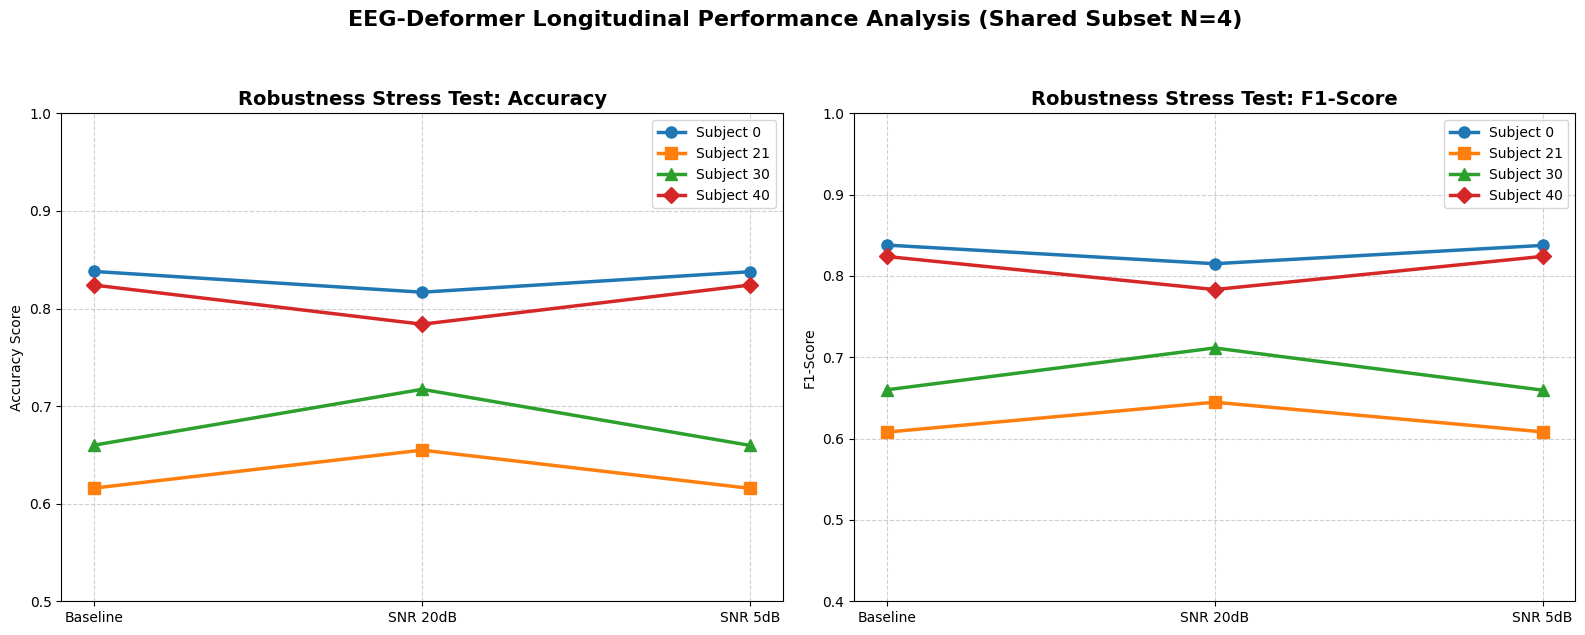


Condition       | Mean Acc   | Mean F1   
--------------------------------------------------
Baseline        | 0.7345     | 0.7325
SNR 20dB        | 0.7432     | 0.7387
SNR 5dB         | 0.7343     | 0.7324


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

path = "/content/drive/MyDrive/MVA/time-series-project/"

df_b = pd.read_csv(path + "baseline_results.csv")
df_20 = pd.read_csv(path + "SNR_20_results.csv")
df_5 = pd.read_csv(path + "SNR_5_results.csv")

for df in [df_b, df_20, df_5]:
    df.columns = df.columns.str.strip()

shared_subs = ['sub0', 'sub21', 'sub30', 'sub40']
conditions = ['Baseline', 'SNR 20dB', 'SNR 5dB']

def get_subset_data(metric_name):
    """Extracts a 2D array of [subjects x conditions] for a specific metric."""
    matrix = []
    for sub in shared_subs:
        row = [
            df_b[df_b['Subject'] == sub][metric_name].values[0],
            df_20[df_20['Subject'] == sub][metric_name].values[0],
            df_5[df_5['Subject'] == sub][metric_name].values[0]
        ]
        matrix.append(row)
    return np.array(matrix)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

#Accuracy Decay
acc_data = get_subset_data('Test_Accuracy')
for i, sub in enumerate(shared_subs):
    ax1.plot(conditions, acc_data[i], marker=markers[i], label=f'Subject {sub[3:]}',
             color=colors[i], linewidth=2.5, markersize=8)

ax1.set_title("Robustness Stress Test: Accuracy", fontsize=14, fontweight='bold')
ax1.set_ylabel("Accuracy Score")
ax1.set_ylim(0.5, 1.0) # Increased limit to see the 'Resilience' better
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

#  F1-Score Decay
f1_data = get_subset_data('Test_F1')
for i, sub in enumerate(shared_subs):
    ax2.plot(conditions, f1_data[i], marker=markers[i], label=f'Subject {sub[3:]}',
             color=colors[i], linewidth=2.5, markersize=8)

ax2.set_title("Robustness Stress Test: F1-Score", fontsize=14, fontweight='bold')
ax2.set_ylabel("F1-Score")
ax2.set_ylim(0.4, 1.0)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.suptitle("EEG-Deformer Longitudinal Performance Analysis (Shared Subset N=4)",
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()


save_name = "submission_robustness_plot.png"
local_path = "./" + save_name
drive_full_path = path + save_name


fig.savefig(local_path, dpi=300, bbox_inches='tight')

# copy from local runtime to Drive
import shutil
shutil.copy(local_path, drive_full_path)

# download
from google.colab import files
files.download(local_path)


plt.show()


# summary
print("\n" + "="*50)
print(f"{'Condition':<15} | {'Mean Acc':<10} | {'Mean F1':<10}")
print("-" * 50)
subset_acc_means = acc_data.mean(axis=0)
subset_f1_means = f1_data.mean(axis=0)

for i, cond in enumerate(conditions):
    print(f"{cond:<15} | {subset_acc_means[i]:.4f}     | {subset_f1_means[i]:.4f}")
print("="*50)

## Channel Masking Experiment

In [ ]:
import torch
import os
import numpy as np
import sys
sys.path.append('/content/EEG-Deformer/EEG-Deformer/')
from models.model_handler import DLModel
from utils import load_data, normalize, get_channel_info, prepare_data_for_training

def evaluate_with_mask(subject_list, snr_path, ckpt_base_path, args, mask_ratio=0.2):
    results = {}

    for sub in subject_list:
        ckpt_path = os.path.join(ckpt_base_path, f'sub{sub}', 'checkpoints')

        if not os.path.exists(ckpt_path):
            print(f"Skipping Subject {sub}: Path not found")
            continue

        ckpt_files = [f for f in os.listdir(ckpt_path) if f.endswith('.ckpt')]
        if not ckpt_files:
            continue
        ckpt_file = os.path.join(ckpt_path, ckpt_files[0])

        # We load to CPU first to strip the 'mps' tag, then move to GPU
        model = DLModel.load_from_checkpoint(
            ckpt_file,
            config=args,
            map_location=torch.device('cpu')
        )
        model.to('cuda')
        model.eval()

        load_path = os.path.join(snr_path, 'data_eeg_FATIG_FTG')
        # Assuming your load_data function is in scope
        data_test, label_test = load_data(load_path=load_path, load_idx=[sub], concat=True)

        # 4. Apply Spatial Mask
        num_channels = data_test.shape[1]
        num_to_mask = int(num_channels * mask_ratio)
        masked_indices = np.random.choice(num_channels, num_to_mask, replace=False)

        data_test_masked = data_test.copy()
        data_test_masked[:, masked_indices, :] = 0

        # 5. Inference
        with torch.no_grad():
            x = torch.from_numpy(data_test_masked).float().to('cuda')
            y_hat = model(x)
            preds = torch.argmax(y_hat, dim=1)
            target = torch.from_numpy(label_test).to('cuda')
            acc = (preds == target).float().mean()

        results[sub] = acc.item()
        print(f"Subject {sub} | Mask {int(mask_ratio*100)}% | Acc: {acc.item():.4f}")

    return results

In [ ]:
import argparse

parser = argparse.ArgumentParser()


######## Data ########
parser.add_argument('--dataset', type=str, default='FATIG')
parser.add_argument('--subjects', type=int, default=11)
parser.add_argument('--num-class', type=int, default=2, choices=[2, 3, 4])
parser.add_argument('--label-type', type=str, default='FTG')
parser.add_argument('--num-chan', type=int, default=30) # 24 for TSception
parser.add_argument('--num-time', type=int, default=384)
parser.add_argument('--segment', type=int, default=4, help='segment length in seconds')
parser.add_argument('--trial-duration', type=int, default=60, help='trial duration in seconds')
parser.add_argument('--overlap', type=float, default=0)
parser.add_argument('--sampling-rate', type=int, default=128)
parser.add_argument('--data-format', type=str, default='eeg')
######## Training Process ########
parser.add_argument('--random-seed', type=int, default=2023)
parser.add_argument('--max-epoch', type=int, default=200)
parser.add_argument('--additional-epoch', type=int, default=20)
parser.add_argument('--batch-size', type=int, default=64)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--dropout', type=float, default=0.5)
parser.add_argument('--val-rate', type=float, default=0.2)

parser.add_argument('--save-path', default='./save/') # change this
parser.add_argument('--load-path', default='./data_processed/') # change this
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--mixed-precision', type=int, default=0)
######## Model Parameters ########
parser.add_argument('--model', type=str, default='Deformer')
parser.add_argument('--graph-type', type=str, default='BL', choices=['LGG-G', 'LGG-F', 'LGG-H', 'TS', 'BL'])
parser.add_argument('--kernel-length', type=int, default=13)
parser.add_argument('--T', type=int, default=64)
parser.add_argument('--AT', type=int, default=16)
parser.add_argument('--num-layers', type=int, default=6)


args = parser.parse_args(args=[])

print("Args defined. You can now run evaluate_with_mask(..., args=args)")

Args defined. You can now run evaluate_with_mask(..., args=args)


In [ ]:
import pandas as pd
import random
ALL_SUBJECTS = [0, 4, 21, 30, 34, 40, 41, 42, 43, 44, 52]
CKPT_BASE = '/content/drive/MyDrive/MVA/time-series-project/final_results/baseline/logs_FATIG_Deformer'
DATA_ROOT = '/content/drive/MyDrive/MVA/time-series-project/data_processed/'


# for reproducibility
np.random.seed(2023)
random.seed(2023)

csv_data = []
masking_summary = {}

all_results = {}
for ratio in [0.1, 0.2, 0.5]:
    print(f"\n--- Testing Spatial Mask Ratio: {int(ratio*100)}% ---")
    sub_results = evaluate_with_mask(ALL_SUBJECTS, DATA_ROOT, CKPT_BASE, args, mask_ratio=ratio)
    all_results[f'mask_{int(ratio*100)}%'] = sub_results
    accuracies = list(sub_results.values())
    masking_summary[ratio] = {
        'mean': np.mean(accuracies),
        'std': np.std(accuracies)
    }

df = pd.DataFrame(all_results)
df.index.name = 'Subject_ID'

df.loc['MEAN'] = df.mean()
df.loc['STD'] = df.std()

output_path = "/content/drive/MyDrive/MVA/time-series-project/spatial_masking_results.csv"
df.to_csv(output_path)

print(f"\nResults successfully saved to: {output_path}")
print(df)



--- Testing Spatial Mask Ratio: 10% ---
Subject 0 | Mask 10% | Acc: 0.5079
Subject 4 | Mask 10% | Acc: 0.1893
Subject 21 | Mask 10% | Acc: 0.7098
Subject 30 | Mask 10% | Acc: 0.4398
Subject 34 | Mask 10% | Acc: 0.4301
Subject 40 | Mask 10% | Acc: 0.7085
Subject 41 | Mask 10% | Acc: 0.6753
Subject 42 | Mask 10% | Acc: 0.3619
Subject 43 | Mask 10% | Acc: 0.4837
Subject 44 | Mask 10% | Acc: 0.5325
Subject 52 | Mask 10% | Acc: 0.5656

--- Testing Spatial Mask Ratio: 20% ---
Subject 0 | Mask 20% | Acc: 0.4974
Subject 4 | Mask 20% | Acc: 0.4229
Subject 21 | Mask 20% | Acc: 0.7137
Subject 30 | Mask 20% | Acc: 0.4031
Subject 34 | Mask 20% | Acc: 0.4338
Subject 40 | Mask 20% | Acc: 0.8492
Subject 41 | Mask 20% | Acc: 0.6039
Subject 42 | Mask 20% | Acc: 0.3753
Subject 43 | Mask 20% | Acc: 0.4085
Subject 44 | Mask 20% | Acc: 0.5854
Subject 52 | Mask 20% | Acc: 0.5410

--- Testing Spatial Mask Ratio: 50% ---
Subject 0 | Mask 50% | Acc: 0.4817
Subject 4 | Mask 50% | Acc: 0.3832
Subject 21 | Mask 5

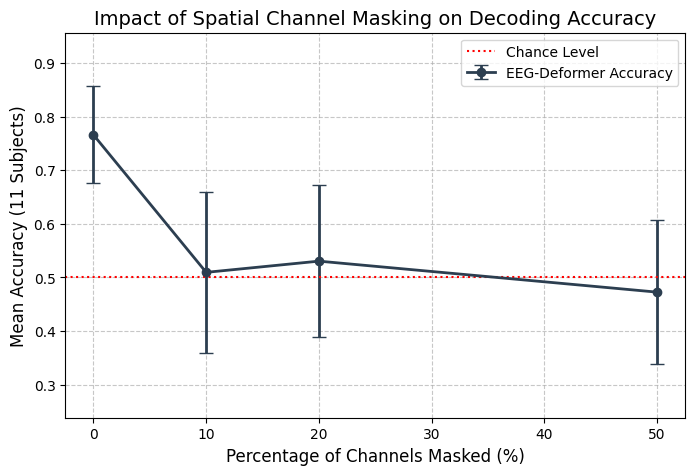

In [ ]:
import matplotlib.pyplot as plt

ratios = [0] + list(masking_summary.keys())
means = np.array([0.7659] + [stats['mean'] for stats in masking_summary.values()])
stds = np.array([0.0905] + [stats['std'] for stats in masking_summary.values()])

fig = plt.figure(figsize=(8, 5))
plt.errorbar([r*100 for r in ratios], means, yerr=stds, fmt='-o',
             capsize=5, color='#2c3e50', linewidth=2, label='EEG-Deformer Accuracy')

plt.title('Impact of Spatial Channel Masking on Decoding Accuracy', fontsize=14)
plt.xlabel('Percentage of Channels Masked (%)', fontsize=12)
plt.ylabel('Mean Accuracy (11 Subjects)', fontsize=12)
lower_bound = np.min(means - stds)
upper_bound = np.max(means + stds)

plt.ylim(max(0, lower_bound - 0.1), min(1.0, upper_bound + 0.1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle=':', label='Chance Level')
plt.legend()

plt.savefig('spatial_robustness_plot.png', dpi=300)
plt.show()

In [ ]:
save_name = "channel_mask.png"
local_path = "./" + save_name
path = "/content/drive/MyDrive/MVA/time-series-project/"
drive_full_path = path + save_name


fig.savefig(local_path, dpi=300, bbox_inches='tight')

# copy from local runtime to Drive
import shutil
shutil.copy(local_path, drive_full_path)

# download
from google.colab import files
files.download(local_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>